# Exploratory Data Analysis
Exploratory data analysis for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [1]:
# Data Analysis
import numpy as np
import pandas as pd
import scipy as sp

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Miscellaneous
import math
import random
import time

# Visualization configurations
pd.set_option('display.max_columns', 60)
plt.style.use('ggplot')
sns.set_style('white')

In [47]:
from collections import Counter

from scipy.stats import chi2_contingency, entropy, f_oneway, pointbiserialr
from scipy.stats.contingency import association

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

### 0.2 Constants

In [3]:
DATA_PATH = '../data/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [4]:
diabetic_data = pd.read_csv(
    DATA_PATH + 'diabetic_data.csv',
    na_values='?',
    keep_default_na=False
)

/tmp/ipykernel_14432/651324338.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetic_data = pd.read_csv(


## **1. Data Understanding**
Exploring the dataset structure from afar.

### 1.1 Dataset structure
Having an overall look at the structure of the dataset.

In [5]:
diabetic_data.sample(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
91092,304851230,141381158,Caucasian,Male,[50-60),NaN,1,7,7,2,CM,NaN,40,0,6,0,0,0,250.42,305,276,9,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30
62100,173048910,38063313,Caucasian,Female,[70-80),NaN,1,22,7,2,NaN,NaN,31,0,19,0,0,0,434,287,414,9,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
41701,128961006,46451025,Caucasian,Male,[60-70),NaN,1,1,7,2,NaN,Gastroenterology,49,0,1,0,0,0,578,455,562,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
58720,166103232,25007112,Caucasian,Male,[80-90),NaN,1,3,7,11,MC,InternalMedicine,53,0,22,0,0,1,486,496,805,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,<30
13392,53341056,2866689,Caucasian,Male,[60-70),NaN,1,18,7,1,NaN,NaN,34,0,18,0,0,0,250.8,996,428,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO


**Feature data types**
- Most features are <u>categorical</u>: demographic, patient characteristics, test results, and medications.
- Some features are <u>numerical</u>: hospital administration related (codes), and patient history related.

In [6]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

**Missing values**
- Weight and payer_code are missing respectively 97% and 40% of values, these can simply be thrown out.
- Medical specialty is also missing 50% of values, but it might be important, and there's a change they can be imputed.
- Very few values for diagnoses and race are missing.

In [7]:
total = diabetic_data.isnull().sum().sort_values(ascending=False)
percent = (diabetic_data.isnull().sum() / diabetic_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
weight,98569,0.968585
medical_specialty,49949,0.490822
payer_code,40256,0.395574
race,2273,0.022336
diag_3,1423,0.013983
diag_2,358,0.003518
diag_1,21,0.000206
admission_type_id,0,0.000000
patient_nbr,0,0.000000
encounter_id,0,0.000000


### 1.2 Feature Distribution
Having an overall look at the distribution of features.

**Distribution of numerical features**
- The encounter and patient identifiers are not useful, will simply be removed.
- The {something}_id features are not actually numerical, but categorical. Those need to be converted to their string representation.
- Almost all other numerical features present outliers way beyond 3-4 Z-scores. 

In [8]:
diabetic_data.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


**Distribution of categorical features**
- Many features (race, gender, age...) have less than 10 values, they can mostly be left as is.
- A few values (change, diabetesMed) are binary, which makes them very easy to handle.
- Some features (medical_specialty, diagnoses) are a huge amount of values, they will require binning somehow.

In [9]:
diabetic_data.describe(include=['O'])

,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,99493,101766,101766,3197,61510,51817,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,10,9,17,72,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),[75-100),MC,InternalMedicine,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,1336,32439,14635,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


## **2. Data Visualization (pre)**
Having an initial look at the relationships between features, before preprocessing.

### 2.0 Functions
General-purpose functions for visual analysis.

#### 2.0.1 Correlation/association measures

In [39]:
def point_biserial_values(data: pd.DataFrame, binary_col: str, numerical_cols: list):
    pb = pd.DataFrame(index=[binary_col], columns=numerical_cols)
    
    for num_col in numerical_cols:
        tmp = data[[binary_col, num_col]].dropna(axis=0)
        
        corr, _ = pointbiserialr(
            x=tmp[binary_col].astype(float),
            y=tmp[num_col]
        )
        pb.loc[binary_col, num_col] = corr
    
    return pb.astype(float)

In [48]:
def anova_values(data: pd.DataFrame, categorical_col: str, numerical_cols: list):
    anova = pd.DataFrame(index=[categorical_col], columns=numerical_cols)
    
    # Get the unique categories
    categories = data[categorical_col].unique()

    for num_col in numerical_cols:
        # Group the numerical values by the categories
        groups = [data[data[categorical_col] == category][num_col] for category in categories]
        
        # Perform ANOVA
        f_val, _ = f_oneway(*groups)
        
        # Store the results
        anova.loc[categorical_col, num_col] = f_val
    
    return anova.astype(float)

In [40]:
def cramer_values(data: pd.DataFrame, columns: list):
    cramer_v = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            contingency_table = pd.crosstab(data[col1], data[col2])
            stat = association(contingency_table, method='cramer')
            cramer_v.loc[col1, col2] = stat
    
    return cramer_v.astype(float)

In [41]:
def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy


def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


def theil_values(data: pd.DataFrame, columns: list):
    theil = pd.DataFrame(index=columns, columns=columns)

    for col1 in columns:
        for col2 in columns:
            stat = theil_u(
                x=data[col1],
                y=data[col2]
            )
            theil.loc[col1, col2] = stat
    
    return theil.astype(float)

#### 2.0.2 Graphs

In [42]:
def heatmap_crosstab(
        data: pd.DataFrame,
        x: str, y: str,
        rows: pd.Index | None = None,
        columns: pd.Index | None = None
):
    """
    Counts occurrences of each combination of categories between two variables,
    then visualize it using a heatmap.
    """
    # Create the crosstab with the specific column order
    crosstab = pd.crosstab(data[y], data[x])
    crosstab = crosstab.reindex(index=rows, columns=columns)

    # Normalize the crosstab to get column-wise percentages
    crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

    # Create an annotation matrix combining counts and percentages
    annotations = np.empty(crosstab.shape, dtype=object)
    for i in range(crosstab.shape[0]):
        for j in range(crosstab.shape[1]):
            count = crosstab.iloc[i, j]
            percent = crosstab_percent.iloc[i, j]

            if pd.isna(count) or pd.isna(percent):
                annotations[i, j] = 'N/A'
            else:
                annotations[i, j] = f'{count}\n({percent:.2f}%)' 

    # Plot the heatmap
    return sns.heatmap(
        crosstab_percent,
        annot=annotations,
        cmap="YlGnBu",
        fmt=''
    )

In [49]:
def point_biserial_matrix(data: pd.DataFrame, binary_col: str, numerical_cols: list, **kwargs):
    pb = point_biserial_values(data, binary_col, numerical_cols)
    
    return sns.heatmap(
        pb,
        annot=True,
        **kwargs
    )


def anova_matrix(data: pd.DataFrame, categorical_col: str, numerical_cols: list, **kwargs):
    anova = anova_values(data, categorical_col, numerical_cols)
    
    return sns.heatmap(
        anova,
        annot=True,
        **kwargs
    )


def cramer_matrix(data: pd.DataFrame, columns: list, **kwargs):
    cramer_v = cramer_values(data, columns)
    
    return sns.heatmap(
        cramer_v,
        annot=True,
        **kwargs
    )


def theil_matrix(data: pd.DataFrame, columns: list, **kwargs):
    theil = theil_values(data, columns)
    
    return sns.heatmap(
        theil,
        annot=True,
        **kwargs
    )

### 2.1 Correlation / Association
Exploring the numeric correlation or association between different features.

#### 2.1.1 Numerical features
- The feature **num_medications** has strong correlation with many other features, especially time spent in hospital and those related to procedures and diagnoses.
- The feature **number_impatient** seems to have a correlation with number_emergency, not particularly strong, but not even weak.

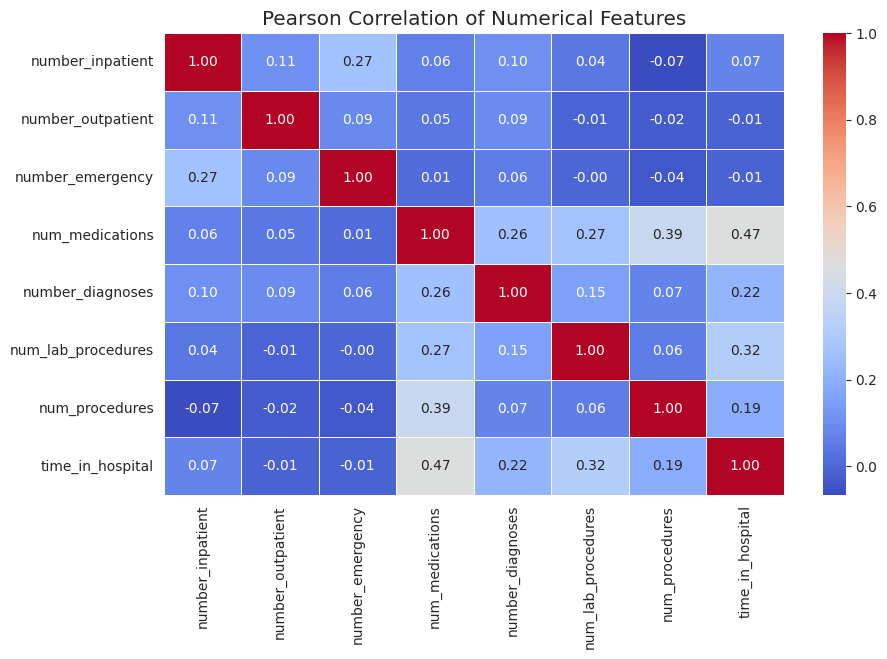

In [58]:
NUMERICAL_COLUMNS = [
    'number_inpatient', 'number_outpatient', 'number_emergency',
    'num_medications', 'number_diagnoses',
    'num_lab_procedures', 'num_procedures', 'time_in_hospital'
]
temp_data = diabetic_data[NUMERICAL_COLUMNS]
data_corr = temp_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Pearson Correlation of Numerical Features')
plt.show()

#### 2.1.2 Categorical features
- The feature **readmitted** has incredibly weak correlation with all categorical features... we're not in luck.
- Closer attention should be kept in consideration to **insulin**, since it shows strong correlation with both change and diabetesMed.
- Some medications show slightly higher association (metformin, glipizide, pioglitazione)... with both change and diabetesMed.

/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in scalar divide
  value = phi2 / min(n_cols - 1, n_rows - 1)
/home/mechamic_38/VSCode_Workspaces/unibs_mldm_diabetes/.venv/lib/python3.12/site-packages/s

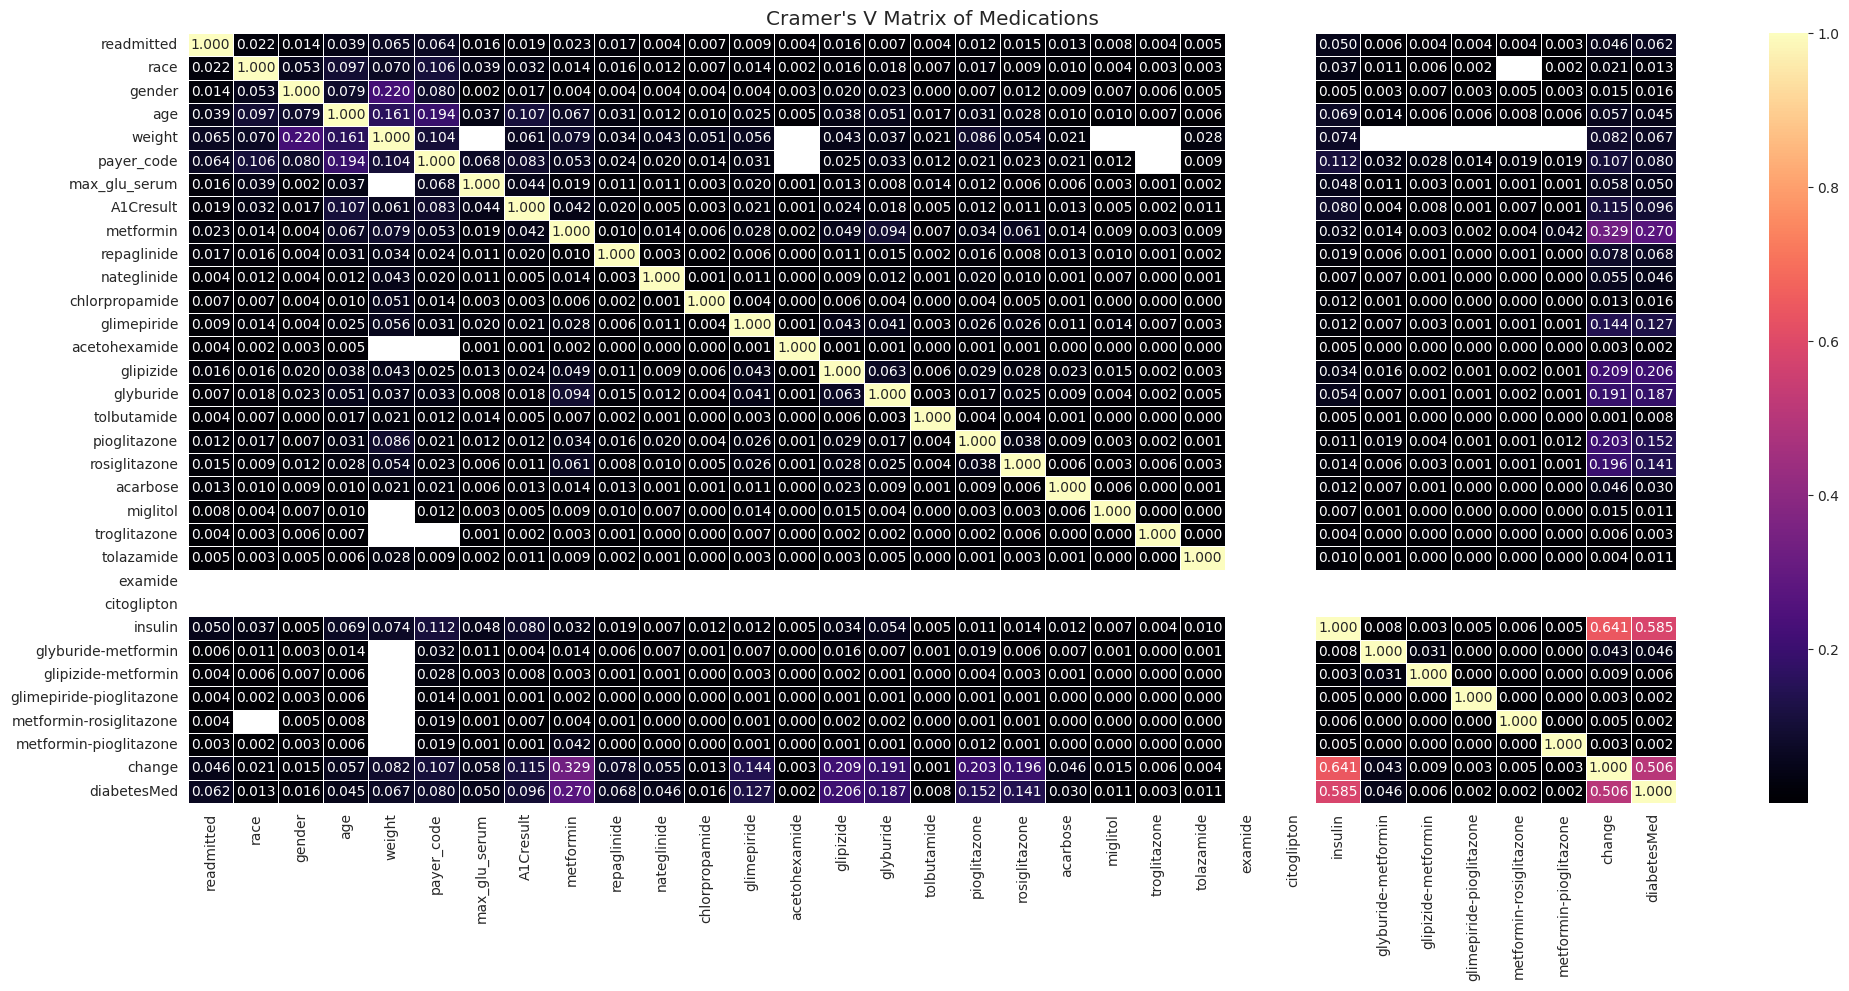

In [44]:
CATEGORICAL_COLUMNS = [
    'readmitted', 'race', 'gender', 'age', 'weight',
    'payer_code', 'max_glu_serum', 'A1Cresult',
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
    'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
    'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
    'metformin-pioglitazone', 'change', 'diabetesMed'
]

plt.figure(figsize=(24, 10))  # Set the figure size
cramer_matrix(
    data=diabetic_data,
    columns=CATEGORICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.3f'
)
plt.title("Cramér's V Matrix of Medications")
plt.show()

#### 2.1.3 Mixed features
- The feature **number_impatient** seems to have a decent association with number_impatient.
- Other features also show a bit of association with readmission (number_diagnosis, number_emergency), but the associations are noticeably weaker.

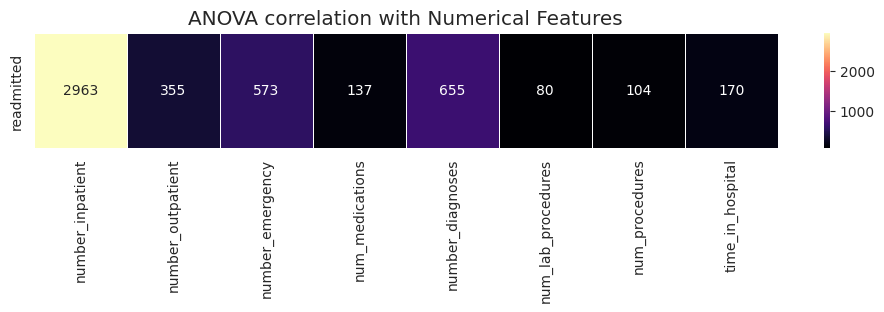

In [57]:
plt.figure(figsize=(12, 1.5))  # Set the figure size
anova_matrix(
    data=diabetic_data,
    categorical_col='readmitted',
    numerical_cols=NUMERICAL_COLUMNS,
    linewidths=0.5,
    cmap = 'magma', fmt='.0f'
)
plt.title('ANOVA correlation with Numerical Features')
plt.show()

### 2.2 Univariate Analysis
Exploring the distribution of values for each feature.

#### 2.2.1 Non-medication features

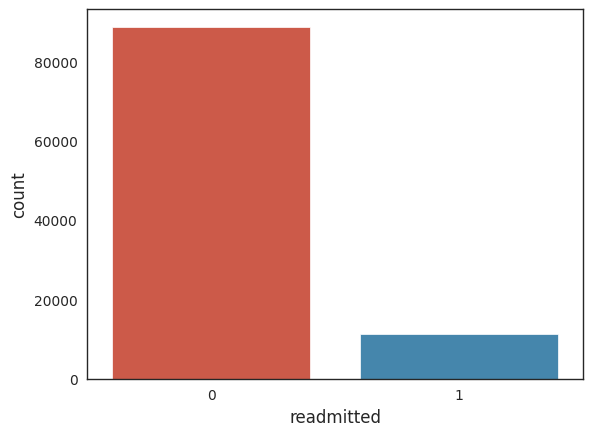

In [328]:
sns.countplot(data=diabetic_data, x='readmitted', hue='readmitted', legend=None)
plt.show()

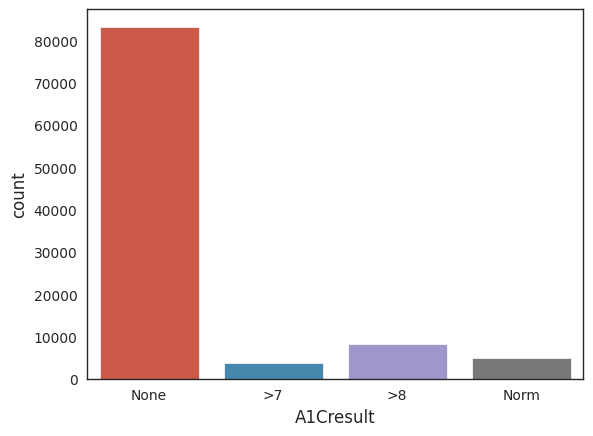

In [329]:
sns.countplot(data=diabetic_data, x='A1Cresult', hue='A1Cresult', legend=None)
plt.show()

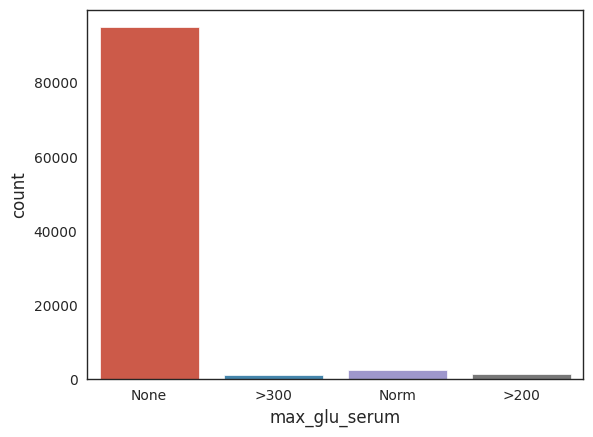

In [330]:
sns.countplot(data=diabetic_data, x='max_glu_serum', hue='max_glu_serum', legend=None)
plt.show()

In [59]:
# sns.countplot(data=diabetic_data, x='medical_specialty_group', hue='medical_specialty_group', legend=None)
# plt.show()

In [60]:
# plt.figure(figsize=(9, 15))
# sns.countplot(
#     data=diabetic_data,
#     y='medical_specialty',
#     hue='medical_specialty_group',
#     stat='percent'
# )
# plt.show()

#### 2.2.2 Medication features

### 2.3 Bivariate Analysis with Readmission
Exploring the relationship of multiple features with readmission status.

#### 2.3.1 Non-medication features

For **A1Cresult**, there doesn't seem to be any direct visible relationship with the readmissions.

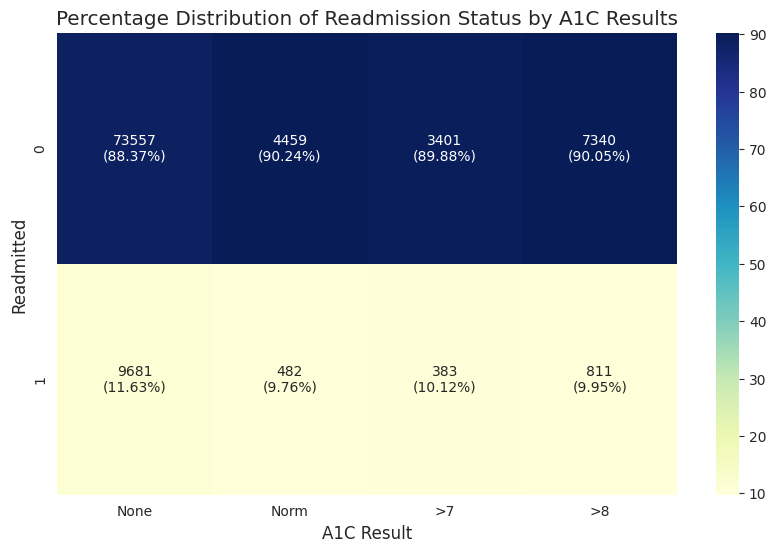

In [333]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='A1Cresult',
    y='readmitted',
    rows=[0, 1],
    columns=['None', 'Norm', '>7', '>8']
)

plt.title('Percentage Distribution of Readmission Status by A1C Results')
plt.xlabel('A1C Result')
plt.ylabel('Readmitted')
plt.show()

For **max_glu_serum**, there is a visible direct correlation with readmission rates. For people that were readmitted within 30 days, but also for those readmitted after 30 days, readmission rates increase with the increase of glucose. For all those people that were not readmitted, there is an inverse relationship with the increase of glucose levels.

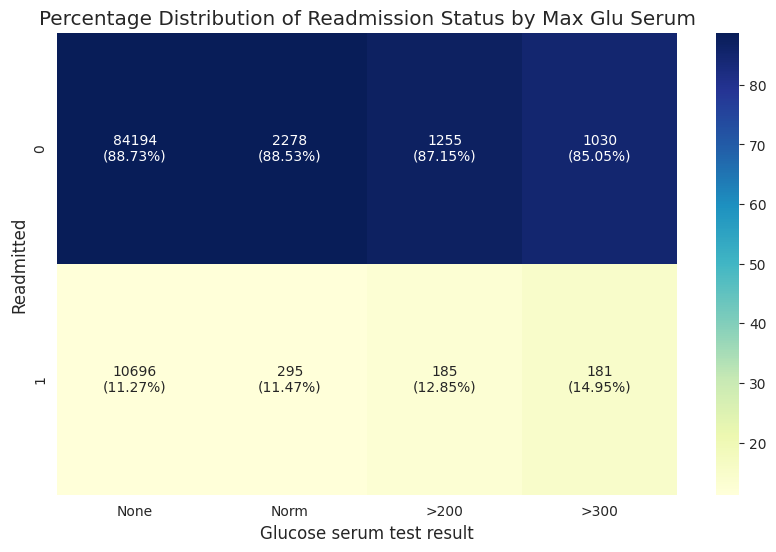

In [334]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='max_glu_serum',
    y='readmitted',
    rows=[0, 1],
    columns=['None', 'Norm', '>200', '>300']
)

plt.title('Percentage Distribution of Readmission Status by Max Glu Serum')
plt.xlabel('Glucose serum test result')
plt.ylabel('Readmitted')
plt.show()

For **age**, there is a very slight correlation with readmission rates. Percentage of readmitted people, both for <30 and >30, is directly proportional up to 20 years. After the 20s, we notice an attenuation of values, meaning that the readmission percentage does not increase as the age increases, but remains stable.

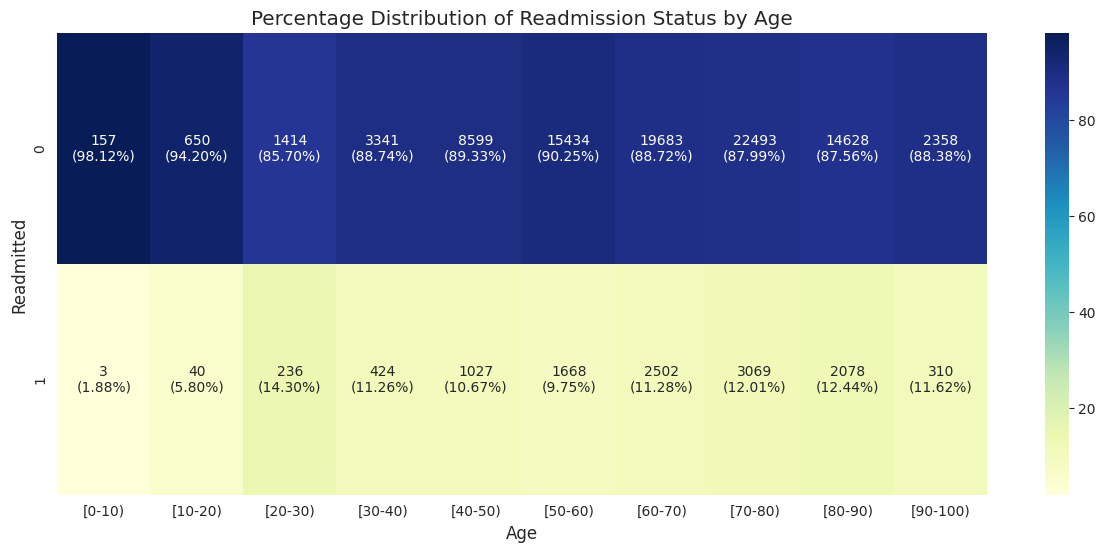

In [335]:
plt.figure(figsize=(15, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='age',
    y='readmitted',
    rows=[0, 1],
    columns=[
        '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
        '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
    ]
)

plt.title('Percentage Distribution of Readmission Status by Age')
plt.xlabel('Age')
plt.ylabel('Readmitted')
plt.show()

For both **gender** and **race**, there is no visible correlation with readmissions. _Too bad, we can't make racist elmo._ 👀

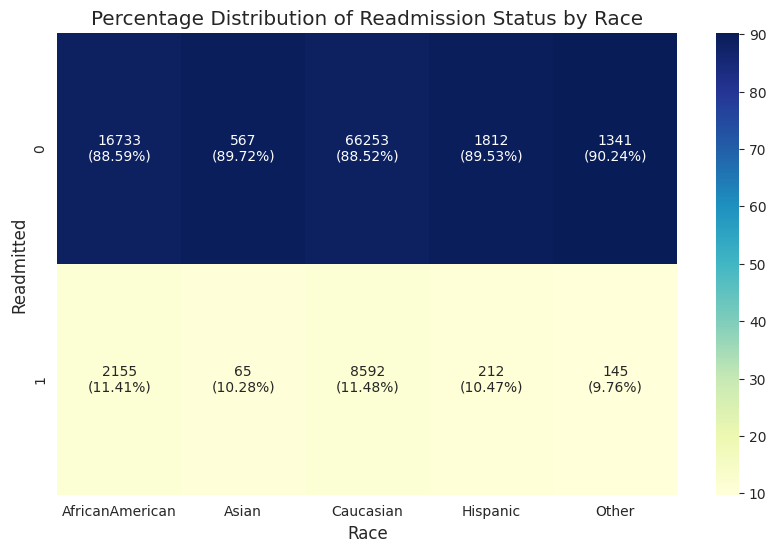

In [336]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='race',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)

plt.title('Percentage Distribution of Readmission Status by Race')
plt.xlabel('Race')
plt.ylabel('Readmitted')
plt.show()

For **num_diagnoses**, there is no visible correlation with readmission.

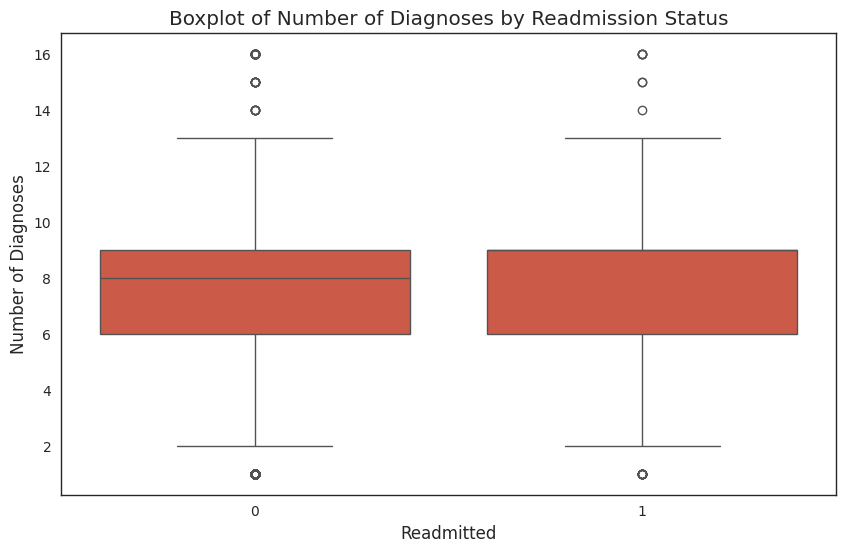

In [337]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_diagnoses')

# Add labels and title
plt.title('Boxplot of Number of Diagnoses by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Diagnoses')

# Show the plot
plt.show()

For **num_medications**, there is no visible correlation with readmission.

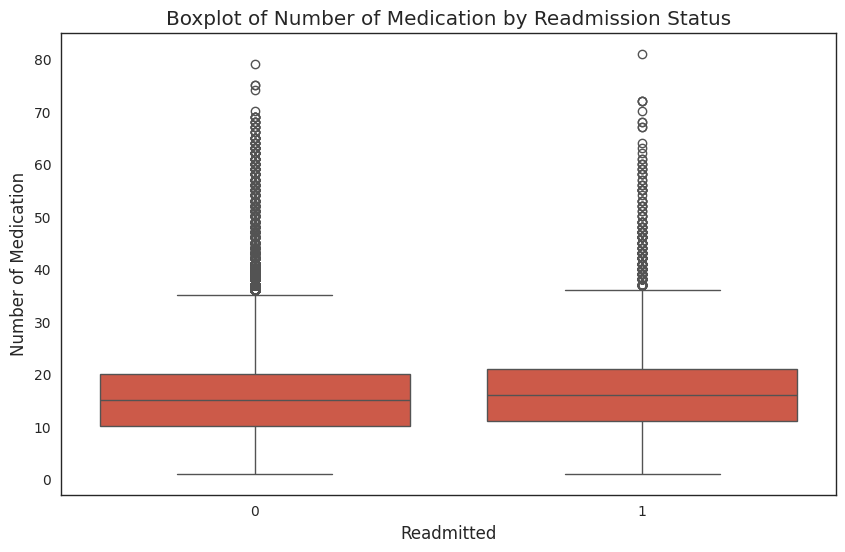

In [338]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_medications')

# Add labels and title
plt.title('Boxplot of Number of Medication by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Medication')

# Show the plot
plt.show()

For **num_lab_procedures**, there is no visible correlation with readmission.

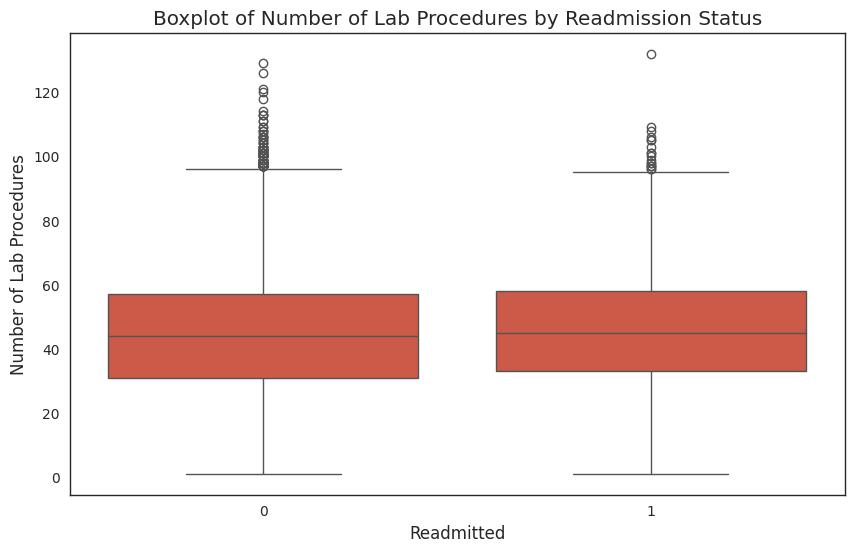

In [339]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_lab_procedures')

# Add labels and title
plt.title('Boxplot of Number of Lab Procedures by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Lab Procedures')

# Show the plot
plt.show()

For **num_procedures**, there is no visible correlation with readmission.

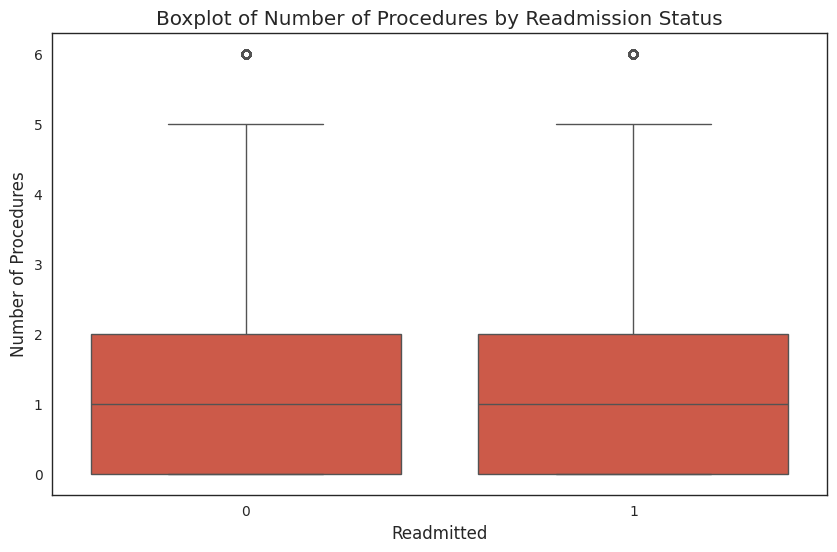

In [340]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_procedures')

# Add labels and title
plt.title('Boxplot of Number of Procedures by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Procedures')

# Show the plot
plt.show()

For **time_in_hospital**, there is no visible correlation with readmission.

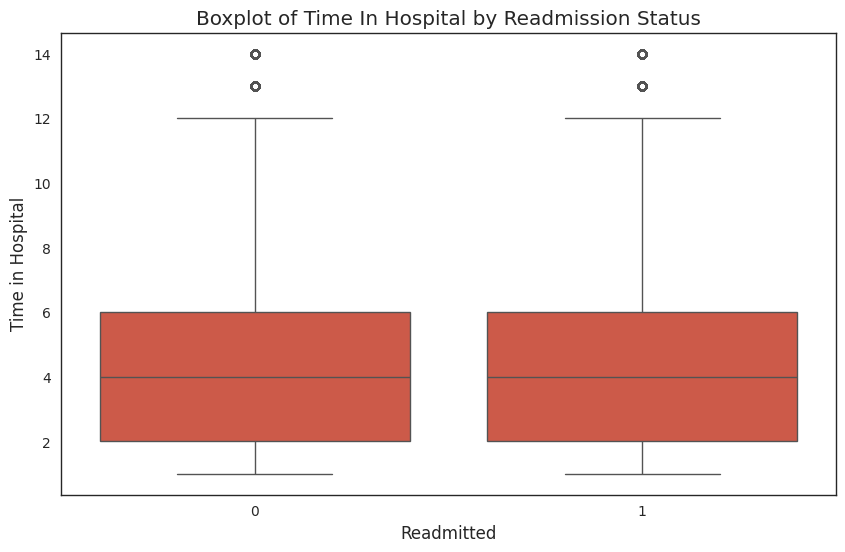

In [341]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='time_in_hospital')

# Add labels and title
plt.title('Boxplot of Time In Hospital by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Time in Hospital')

# Show the plot
plt.show()

For **num_inpatient**, positive correlation is immediately noticeable.

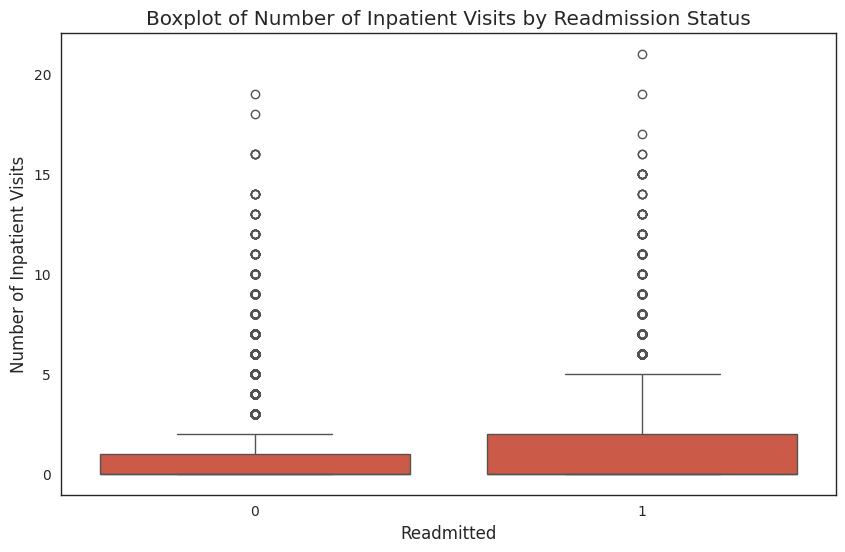

In [342]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_inpatient')

# Add labels and title
plt.title('Boxplot of Number of Inpatient Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Inpatient Visits')

# Show the plot
plt.show()

For **num_outpatient**, there is no visible correlation with readmission. By the looks of it, it's not even worth it to handle outlier values.

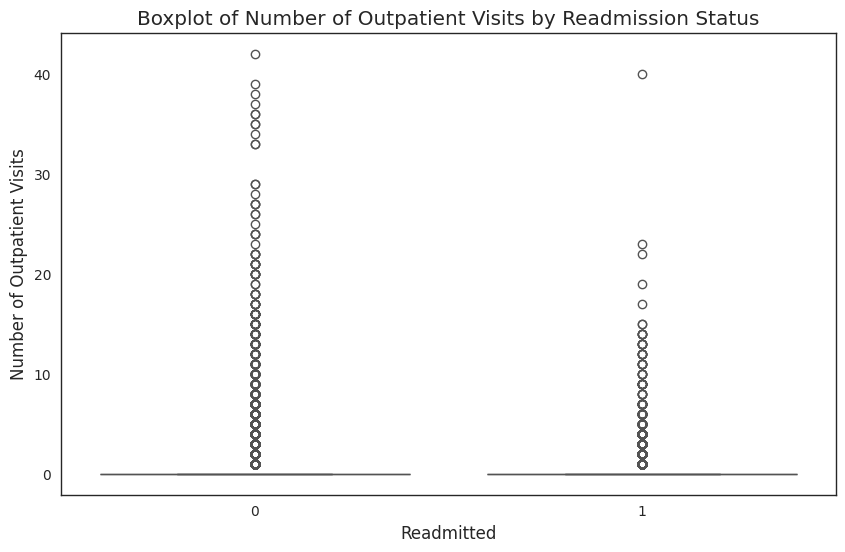

In [343]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_outpatient')

# Add labels and title
plt.title('Boxplot of Number of Outpatient Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Outpatient Visits')

# Show the plot
plt.show()

For **num_emergency**, there is no visible correlation with readmission. By the looks of it, it's not even worth it to handle outlier values.

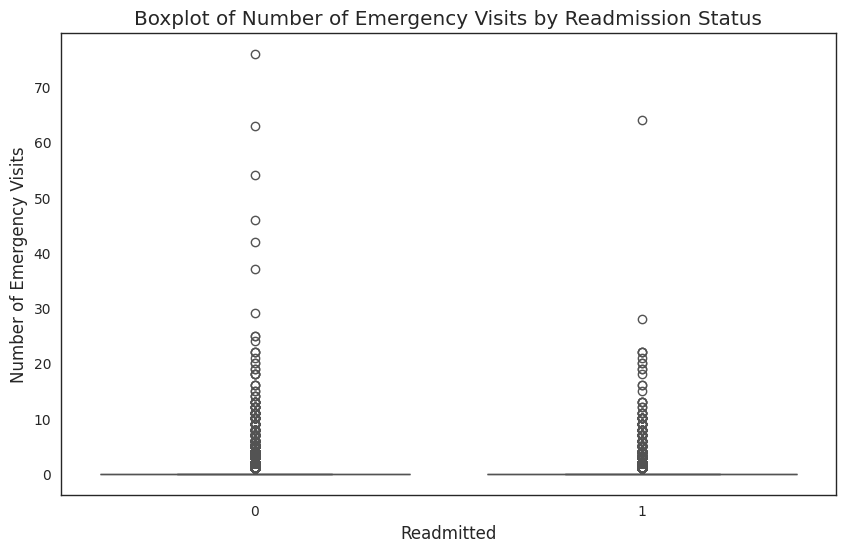

In [344]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='num_emergency')

# Add labels and title
plt.title('Boxplot of Number of Emergency Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Emergency Visits')

# Show the plot
plt.show()

For **diabetes_med_change**, there is a small correlation with readmissions. A change in medication seems to lead to easier readmission.

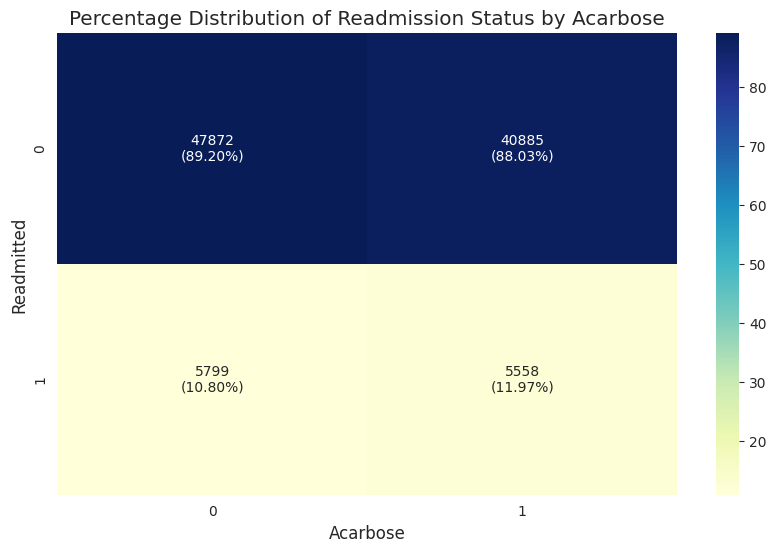

In [345]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diabetes_med_change',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **diabetes_med_provided**, there is a small correlation with readmissions. Subministration of diabetes medications seems to lead to easier readmission.

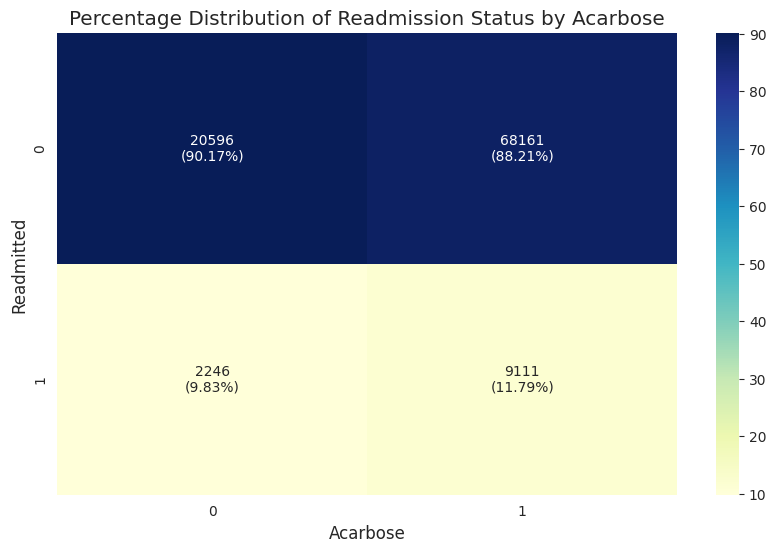

In [346]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diabetes_med_provided',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **admission_type**, there is no visible correlation with readmissions.

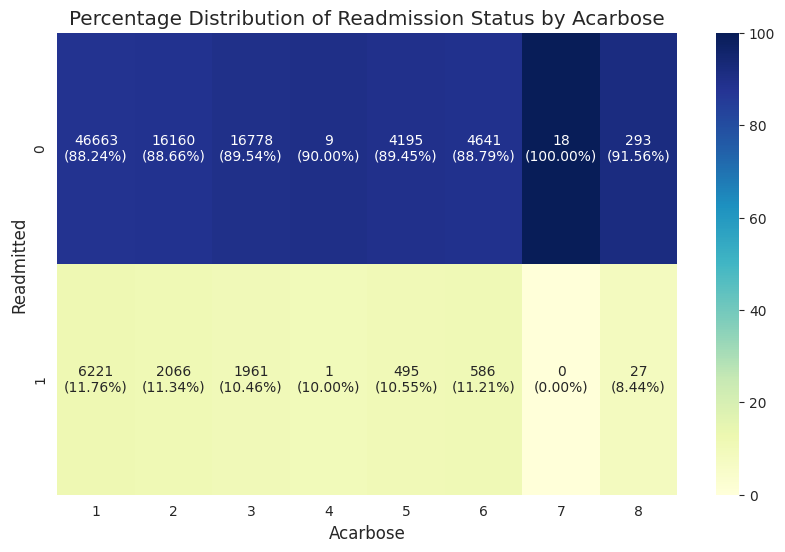

In [351]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='admission_type_id',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

#### 2.3.2 Medication features

For **insulin**, if you leave unmodified, everything is fine... if you change the dosage, shit hits the fan.

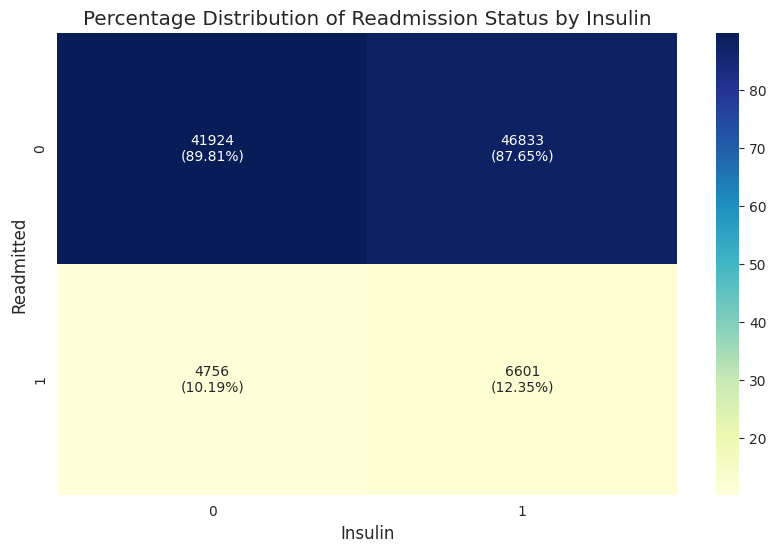

In [354]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='insulin',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)

plt.title('Percentage Distribution of Readmission Status by Insulin')
plt.xlabel('Insulin')
plt.ylabel('Readmitted')
plt.show()

For **Sulfonylureas**, there were too few administrations, and for those that had the most subministrations, there wasn't any visible difference between readmitted and not readmitted.

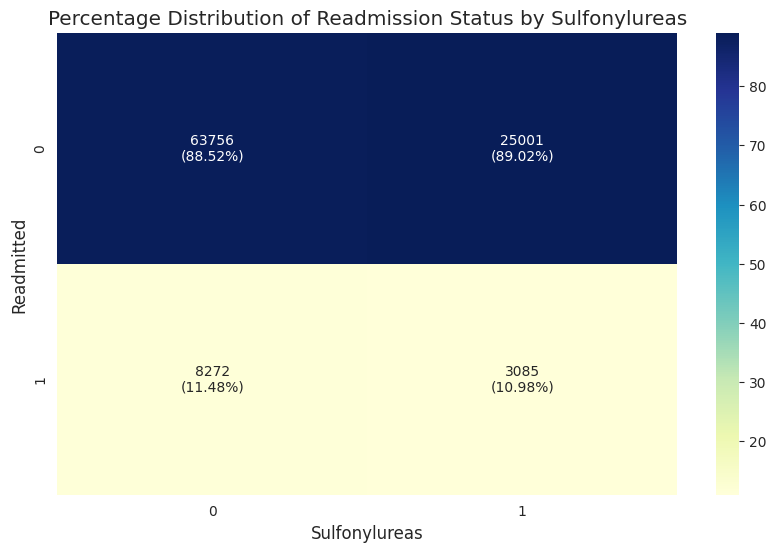

In [355]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='sulfonylurea',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)

plt.title('Percentage Distribution of Readmission Status by Sulfonylureas')
plt.xlabel('Sulfonylureas')
plt.ylabel('Readmitted')
plt.show()

For **TZDs**, there were any visible difference between readmitted and not readmitted.

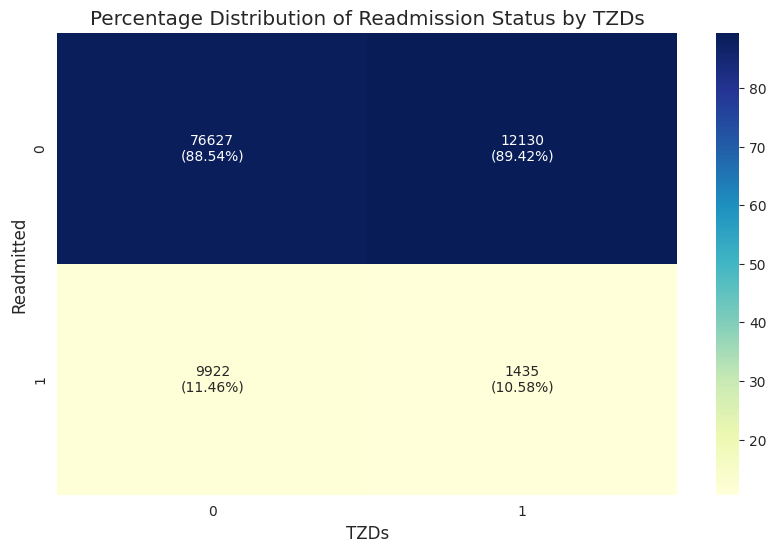

In [356]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='TZD',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by TZDs')
plt.xlabel('TZDs')
plt.ylabel('Readmitted')
plt.show()

For **combination_medications**, this dataset sucks ass.

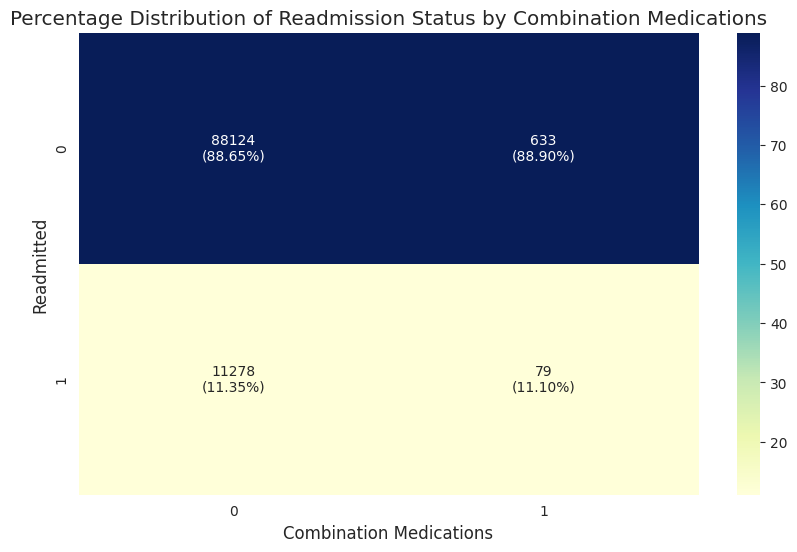

In [357]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='combination_med',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Combination Medications')
plt.xlabel('Combination Medications')
plt.ylabel('Readmitted')
plt.show()

For **meglitidines**...

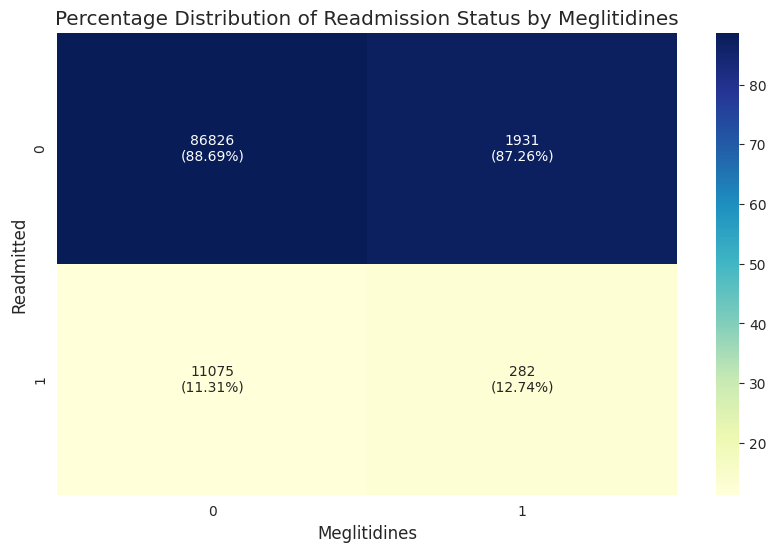

In [358]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='meglitidine',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Meglitidines')
plt.xlabel('Meglitidines')
plt.ylabel('Readmitted')
plt.show()

For **AG_inhibitor**...

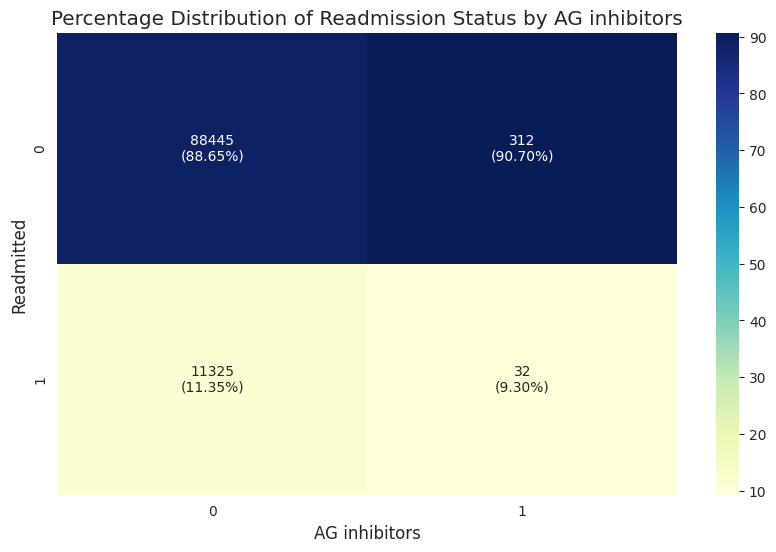

In [359]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='AG_inhibitor',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by AG inhibitors')
plt.xlabel('AG inhibitors')
plt.ylabel('Readmitted')
plt.show()

For **metmorfin**, there is no visible correlation whatsover...

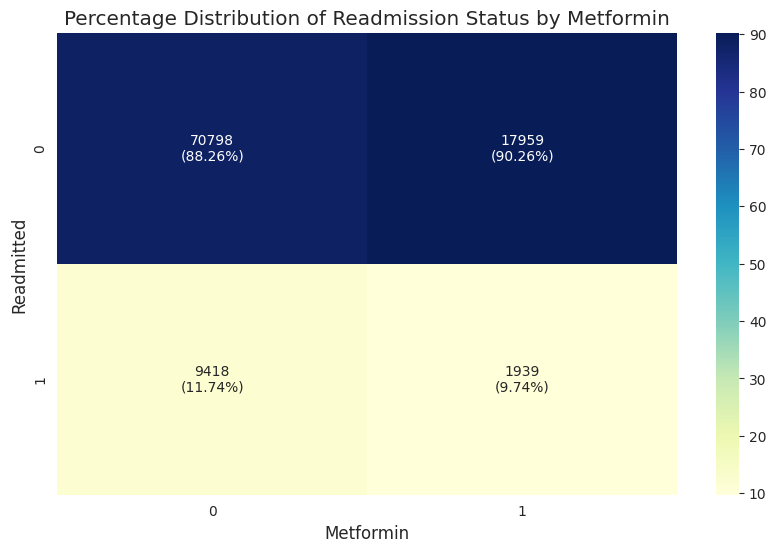

In [360]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='metformin',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)

plt.title('Percentage Distribution of Readmission Status by Metformin')
plt.xlabel('Metformin')
plt.ylabel('Readmitted')
plt.show()

For **troglitazone**, no sufficient data is available.

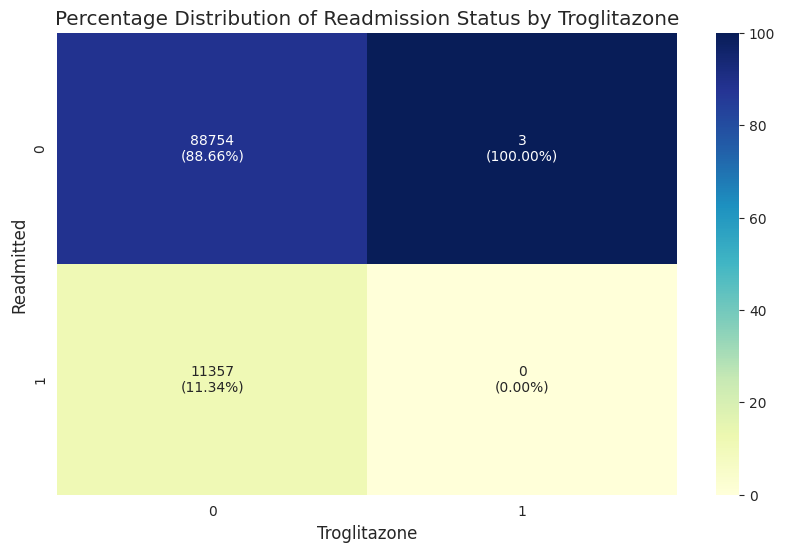

In [361]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='troglitazone',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Troglitazone')
plt.xlabel('Troglitazone')
plt.ylabel('Readmitted')
plt.show()

For **repaglinide**, there are very few subministrations, but when they happen it seems to lead to easier readmission.

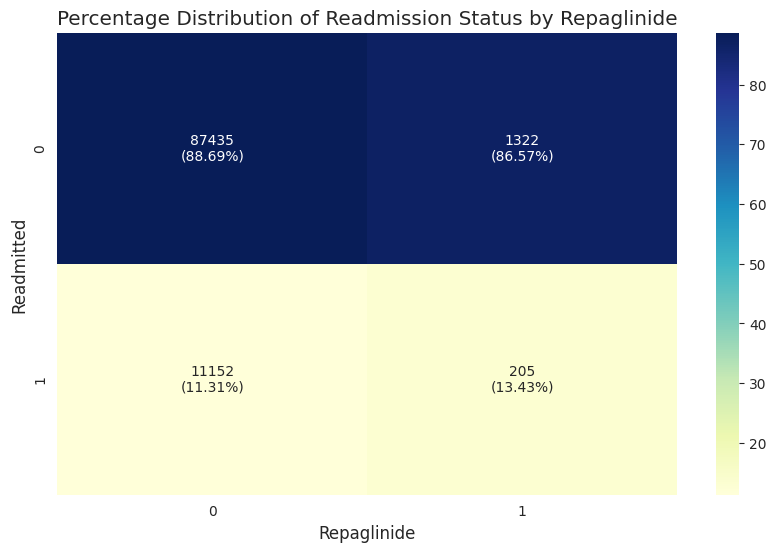

In [362]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='repaglinide',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Repaglinide')
plt.xlabel('Repaglinide')
plt.ylabel('Readmitted')
plt.show()

For **nateglinide**, there is no real correlation visible, and very few subministrations overall.

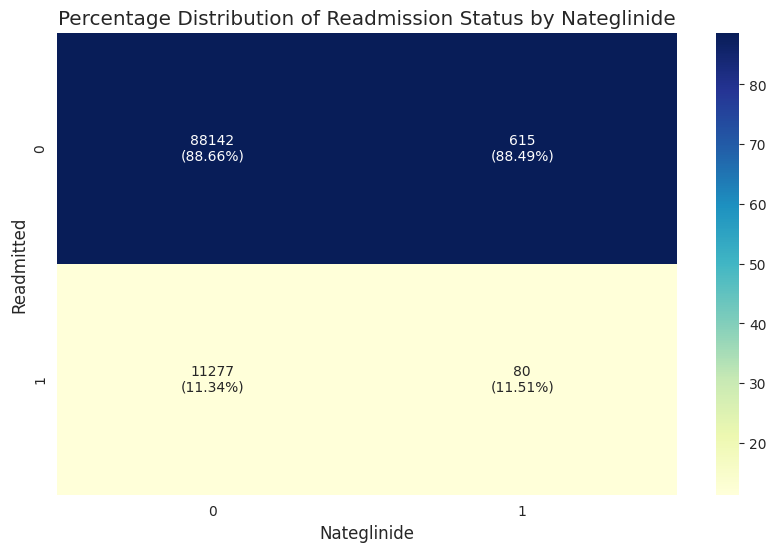

In [363]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='nateglinide',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Nateglinide')
plt.xlabel('Nateglinide')
plt.ylabel('Readmitted')
plt.show()

For **examide**, well...

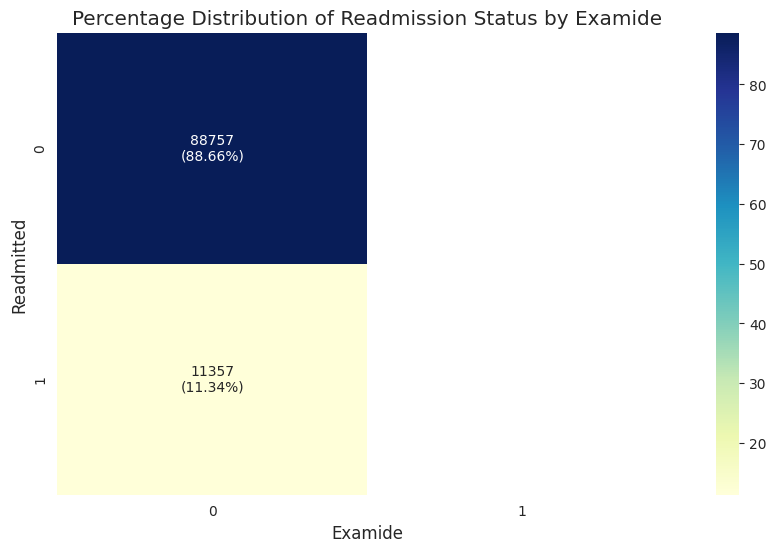

In [364]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='examide',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Examide')
plt.xlabel('Examide')
plt.ylabel('Readmitted')
plt.show()

For **acarbose**, since there were too few instances, probably it's not very important, so we can remove it from the dataset.

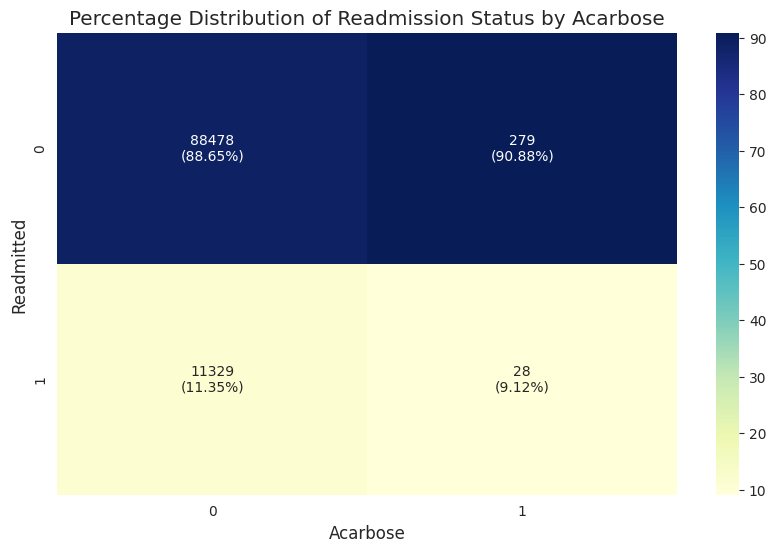

In [365]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='acarbose',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Acarbose')
plt.xlabel('Acarbose')
plt.ylabel('Readmitted')
plt.show()

For **miglitol**, since there were too few instances, probably it's not very important, so we can remove it from the dataset.

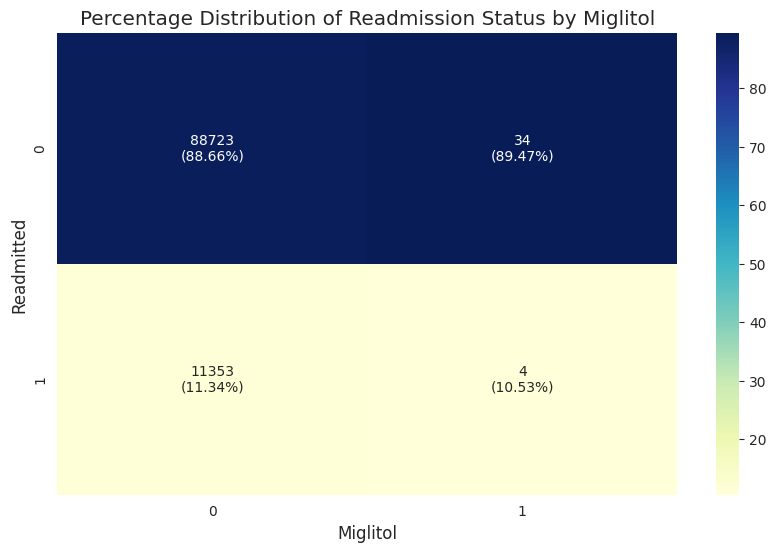

In [366]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='miglitol',
    y='readmitted',
    rows=[0, 1],
    columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Miglitol')
plt.xlabel('Miglitol')
plt.ylabel('Readmitted')
plt.show()

### 2.4 Multivariate Analysis
Exploring the relationships between multiple features at once.

## **3. Preprocessing**
Modifying and casting data, imputing missing values, creating new features, and so on.

### 3.0 Functions

In [ ]:
def map_icd9_codes(icd9_code):
    # Handle missing values
    if pd.isnull(icd9_code):
        return None

    # Handle special ICD-9 codes (E-V)
    try:
        code = float(icd9_code)
    except ValueError:
        return 'Other'

    if 390 <= code <= 459:
        return 'Circulatory'
    elif 460 <= code <= 519:
        return 'Respiratory'
    elif 520 <= code <= 579:
        return 'Digestive'
    elif 250 <= code < 251:
        return 'Diabetes'
    elif 800 <= code <= 999:
        return 'Injury'
    elif 710 <= code <= 739:
        return 'Musculoskeletal'
    elif 580 <= code <= 629:
        return 'Genitourinary'
    elif 140 <= code <= 239:
        return 'Neoplasms'
    else:
        return 'Other'

In [ ]:
def map_admission_source(admission_src_id):
    # Handle missing values
    if pd.isnull(admission_src_id):
        return None
    
    if admission_src_id in [1, 2, 3]:
        return 'Referral'
    elif admission_src_id in [4, 5, 6, 10, 18, 22, 25, 26]:
        return 'Transfer from Another Facility'
    elif admission_src_id in [7, 8]:
        return 'Emergency or Law Enforcement'
    else:
        return 'Other'

In [ ]:
def map_discharge_disposition(discharge_disp_id):
    # Handle missing values
    if pd.isnull(discharge_disp_id):
        return None
    
    if discharge_disp_id in [1, 6, 8]:
        return 'Home / Home Care'
    elif discharge_disp_id in [2, 3, 4, 5, 10, 15, 16, 17, 22, 23, 24, 27, 28, 29, 30]:
        return 'Transfer to Another Facility'
    elif discharge_disp_id in [11, 19, 20, 21]:
        return 'Expired'
    elif discharge_disp_id in [13, 14]:
        return 'Hospice Care'
    else:
        return 'Other'

In [ ]:
def map_medical_specialty(medical_specialty):
    # Handle missing values
    if pd.isnull(medical_specialty):
        return None
    
    if medical_specialty == 'InternalMedicine':
        return 'Internal Medicine'
    
    elif medical_specialty == 'Family/GeneralPractice':
        return 'Family/General Practice'
    
    elif medical_specialty == 'Emergency/Trauma':
        return 'Emergency/Trauma'
    
    elif medical_specialty in [
        'Surgeon', 'Surgery-Colon&Rectal',
        'Surgery-General', 'Surgery-Maxillofacial', 'Surgery-Neuro',
        'Surgery-Pediatric', 'Surgery-Plastic',
        'Surgery-PlasticwithinHeadandNeck', 'Surgery-Thoracic',
        'Surgery-Vascular', 'SurgicalSpecialty'
    ]:
        return 'Surgery'
    
    elif medical_specialty in [
        'Cardiology', 'Surgery-Cardiovascular',
        'Surgery-Cardiovascular/Thoracic'
    ]:
        return 'Cardiology'
    
    else:
        return 'Other'

### 3.1 Data Pre-Cleaning

#### 3.1.1 Duplicates
Looking for duplicate instances, by excluding the reference to the patient and encounter identifiers. Luckily, there are none of them.

In [ ]:
temp_data = diabetic_data.drop(columns=['patient_nbr'])
duplicates = temp_data[temp_data.duplicated()]
duplicates

,encounter_id,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted


#### 3.1.2 Incomplete/irrelevant features
Dropping columns with too many missing values, or that are irrelevant for the analysis.

In [ ]:
diabetic_data = diabetic_data.drop(columns=[
    'encounter_id', 'weight', 'race', 'payer_code'
])
diabetic_data.sample(5)

,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
17066,4846122,Female,[50-60),3,6,1,6,Urology,38,4,26,0,0,0,592,285,518,5,None,None,Up,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
73296,104501862,Male,[80-90),3,1,1,1,Cardiology,30,3,11,1,0,0,427,414,V45,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
77852,84372759,Male,[50-60),2,1,1,1,Radiologist,43,6,22,5,0,0,414,278,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,<30
42687,89166312,Female,[70-80),1,6,7,6,NaN,9,0,7,0,0,0,514,786,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
70186,90905400,Female,[50-60),1,1,7,3,Psychiatry,7,0,7,0,0,1,295,250,NaN,2,None,None,Steady,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


### 3.2 Feature Engineering

#### 3.2.1 Renaming features

In [ ]:
diabetic_data = diabetic_data.rename(columns={
    'number_inpatient': 'num_inpatient',
    'number_outpatient': 'num_outpatient',
    'number_emergency': 'num_emergency',
    'number_diagnoses': 'num_diagnoses',
    'change': 'diabetes_med_change',
    'diabetesMed': 'diabetes_med_provided'
})

#### 3.2.2 Readmissions
Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: `readmitted`, if the patient was readmitted within 30 days of discharge or `otherwise`, which covers both readmission after 30 days and no readmission at all.

In [ ]:
diabetic_data['readmitted'] = diabetic_data['readmitted'].replace(
    {
        '<30': 1,
        'NO': 0,
        '>30': 0
    }
)

/tmp/ipykernel_10321/2602672348.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['readmitted'] = diabetic_data['readmitted'].replace(


#### 3.2.3 Diagnoses

Mapping **diag_1**, **diag_2** and **diag_3** in macro-categories.

In [ ]:
diabetic_data['diag_1_group'] = diabetic_data['diag_1'].apply(map_icd9_codes)
diabetic_data['diag_2_group'] = diabetic_data['diag_2'].apply(map_icd9_codes)
diabetic_data['diag_3_group'] = diabetic_data['diag_3'].apply(map_icd9_codes)

#### 3.2.4 Admission sources

Mapping **admission_source_id** in macro-categories.
**USE K-Nearest Neighbor to approximate missing values (Not Available, Not Mapped, NULL)**

Not Available e null sono identici, in entrambi i casi il valore non è disponibile.

Not Mapped può avere un significato diverso, nel senso che il valore non è stato preso perché non importante.

In [ ]:
diabetic_data['admission_source_id'].value_counts().sort_values(ascending=False)

admission_source_id
7     57494
1     29565
17     6781
4      3187
6      2264
2      1104
5       855
3       187
20      161
9       125
8        16
22       12
10        8
14        2
11        2
25        2
13        1
Name: count, dtype: int64

In [ ]:
diabetic_data['admission_source_group'] = diabetic_data['admission_source_id'].apply(map_admission_source)

#### 3.2.5 Discharge dispositions

Mapping **discharge_disposition_id** in macro-categories. **MAY REQUIRE to remove all patients that died from the dataset... maybe also those sent to hospices.**

In [ ]:
diabetic_data['discharge_disposition_id'].value_counts().sort_values(ascending=False)

discharge_disposition_id
1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: count, dtype: int64

In [ ]:
diabetic_data['discharge_disposition_group'] = diabetic_data['discharge_disposition_id'].apply(map_discharge_disposition)

#### 3.2.6 Medical specialties

Mapping **medical_specialty** to macro-categories.

In [ ]:
diabetic_data['medical_specialty'].sort_values(ascending=True).unique()

array(['AllergyandImmunology', 'Anesthesiology',
       'Anesthesiology-Pediatric', 'Cardiology', 'Cardiology-Pediatric',
       'DCPTEAM', 'Dentistry', 'Dermatology', 'Emergency/Trauma',
       'Endocrinology', 'Endocrinology-Metabolism',
       'Family/GeneralPractice', 'Gastroenterology', 'Gynecology',
       'Hematology', 'Hematology/Oncology', 'Hospitalist',
       'InfectiousDiseases', 'InternalMedicine', 'Nephrology',
       'Neurology', 'Neurophysiology',
       'Obsterics&Gynecology-GynecologicOnco', 'Obstetrics',
       'ObstetricsandGynecology', 'Oncology', 'Ophthalmology',
       'Orthopedics', 'Orthopedics-Reconstructive', 'Osteopath',
       'Otolaryngology', 'OutreachServices', 'Pathology', 'Pediatrics',
       'Pediatrics-AllergyandImmunology', 'Pediatrics-CriticalCare',
       'Pediatrics-EmergencyMedicine', 'Pediatrics-Endocrinology',
       'Pediatrics-Hematology-Oncology', 'Pediatrics-InfectiousDiseases',
       'Pediatrics-Neurology', 'Pediatrics-Pulmonology', 'Per

In [ ]:
diabetic_data['medical_specialty_group'] = diabetic_data['medical_specialty'].apply(map_medical_specialty)

#### 3.2.7 Diabetes medication and changes

In [ ]:
# Making change and subministration of diabetes medication boolean
diabetic_data['diabetes_med_change'] = diabetic_data['diabetes_med_change'].replace(
    {
        'No': 0,
        'Ch': 1
    }
)
diabetic_data['diabetes_med_provided'] = diabetic_data['diabetes_med_provided'].replace(
    {
        'No': 0,
        'Yes': 1
    }
)

/tmp/ipykernel_10321/88342666.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['diabetes_med_change'] = diabetic_data['diabetes_med_change'].replace(
/tmp/ipykernel_10321/88342666.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data['diabetes_med_provided'] = diabetic_data['diabetes_med_provided'].replace(


#### 3.2.8 Medications

Convert subministration or not subministration of medications into boolean values.

In [ ]:
diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'] = diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'].replace(
    {
        'No': 0,
        'Steady': 1,
        'Up': 1,
        'Down': 1
    }
)

/tmp/ipykernel_10321/783719850.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'] = diabetic_data.loc[:, 'metformin':'metformin-pioglitazone'].replace(


Group all medications of the same type.

In [ ]:
diabetic_data['sulfonylurea'] = diabetic_data[['chlorpropamide', 'glimepiride', 'glipizide', 'glyburide', 'tolbutamide', 'tolazamide']].any(axis=1)
diabetic_data['TZD'] = diabetic_data[['pioglitazone', 'rosiglitazone']].any(axis=1)
diabetic_data['combination_med'] = diabetic_data[['glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']].any(axis=1)
diabetic_data['meglitidine'] = diabetic_data[['repaglinide', 'nateglinide']].any(axis=1)
diabetic_data['AG_inhibitor'] = diabetic_data[['acarbose', 'miglitol']].any(axis=1)

### 3.3 Imputation

#### 3.3.1 Diagnoses

In [ ]:
imputer = SimpleImputer(missing_values=None, strategy='most_frequent')

# Imputing diag_1_group
# diag_1_null = diabetic_data['diag_1_group'].isnull()
diabetic_data['diag_1_group'] = pd.DataFrame(imputer.fit_transform(diabetic_data[['diag_1_group']]))

# Imputing diag_2_group
# diag_2_null = diabetic_data['diag_2_group'].isnull()
diabetic_data['diag_2_group'] = pd.DataFrame(imputer.fit_transform(diabetic_data[['diag_2_group']]))

# Imputing diag_3_group
# diag_3_null = diabetic_data['diag_3_group'].isnull()
diabetic_data['diag_3_group'] = pd.DataFrame(imputer.fit_transform(diabetic_data[['diag_3_group']]))

#### 3.3.2 Medical Specialty

In [ ]:
msg_null = diabetic_data['medical_specialty_group'].isnull()
diabetic_data[msg_null].sample(10)

,patient_nbr,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,num_outpatient,num_emergency,num_inpatient,diag_1,diag_2,diag_3,num_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,diabetes_med_change,diabetes_med_provided,readmitted,diag_1_group,diag_2_group,diag_3_group,admission_source_group,discharge_disposition_group,medical_specialty_group,sulfonylurea,TZD,combination_med,meglitidine,AG_inhibitor
17306,56325978,Male,[70-80),1,11,7,9,NaN,82,5,30,0,0,2,482,496,518,8,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,Respiratory,Respiratory,Respiratory,Emergency or Law Enforcement,Expired,None,False,False,False,False,False
87417,100340703,Female,[70-80),1,5,7,5,NaN,39,0,13,0,0,0,296,303,250.6,6,None,>8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,Other,Other,Diabetes,Emergency or Law Enforcement,Transfer to Another Facility,None,False,False,False,False,False
71298,87192819,Female,[70-80),1,1,7,2,NaN,10,0,10,0,0,0,401,276,786,8,None,None,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,Circulatory,Other,Other,Emergency or Law Enforcement,Home / Home Care,None,False,True,False,False,False
61627,85728087,Male,[50-60),1,1,7,8,NaN,62,6,36,0,0,0,569,578,250,9,None,Norm,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Digestive,Digestive,Diabetes,Emergency or Law Enforcement,Home / Home Care,None,False,False,False,False,False
43329,90137133,Female,[60-70),1,6,7,6,NaN,68,0,16,1,0,0,434,401,272,9,None,None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Circulatory,Circulatory,Other,Emergency or Law Enforcement,Home / Home Care,None,False,False,False,False,False
15017,3422214,Male,[80-90),1,18,7,9,NaN,36,3,14,0,0,0,410,428,427,7,None,None,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,Circulatory,Circulatory,Circulatory,Emergency or Law Enforcement,Other,None,True,False,False,False,False
23115,24310071,Female,[80-90),6,25,17,3,NaN,23,1,14,0,1,0,331,599,486,8,Norm,None,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,Other,Genitourinary,Respiratory,Other,Other,None,True,False,False,False,False
81465,59495292,Female,[60-70),1,1,7,4,NaN,62,0,24,0,0,1,255,599,584,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,Other,Genitourinary,Genitourinary,Emergency or Law Enforcement,Home / Home Care,None,False,False,False,False,False
1978,59710869,Female,[70-80),1,1,7,3,NaN,67,2,13,0,0,1,512,250.01,496,9,None,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,Respiratory,Diabetes,Respiratory,Emergency or Law Enforcement,Home / Home Care,None,False,False,False,False,False
18782,23689440,Female,[70-80),5,1,17,2,NaN,17,2,13,0,2,1,733,250,V10,3,Norm,None,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,Musculoskeletal,Diabetes,Other,Other,Home / Home Care,None,False,False,False,False,False


#### 3.3.3 After imputation

In [ ]:
total = diabetic_data.isnull().sum().sort_values(ascending=False)
percent = (diabetic_data.isnull().sum() / diabetic_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
medical_specialty,49949,0.490822
medical_specialty_group,49949,0.490822
diag_3,1423,0.013983
diag_2,358,0.003518
diag_1,21,0.000206
discharge_disposition_id,0,0.000000
gender,0,0.000000
admission_type_id,0,0.000000
patient_nbr,0,0.000000
num_lab_procedures,0,0.000000


### 3.4 Data Post-Cleaning

#### 3.4.1 Expired patients
Removing all expired (dead) patients, since they do not count towards readmission.

In [ ]:
diabetic_data = diabetic_data[
    diabetic_data['discharge_disposition_group'] != 'Expired'
]

## **4. Data Visualization (after)**
Having a more thourough look at the relationships between features, after preprocessing.

### 4.1 Correlation / Association
Exploring the numeric correlation or association between different features.

#### 4.1.1 Numerical features
Above, the only numerical relation that exists with readmissions is related to the number of inpatient visits. Other features present very little or absent correlation with readmission status.

Below, correlation of numerical features with readmitted (binary), by using Point Biserial correlation.

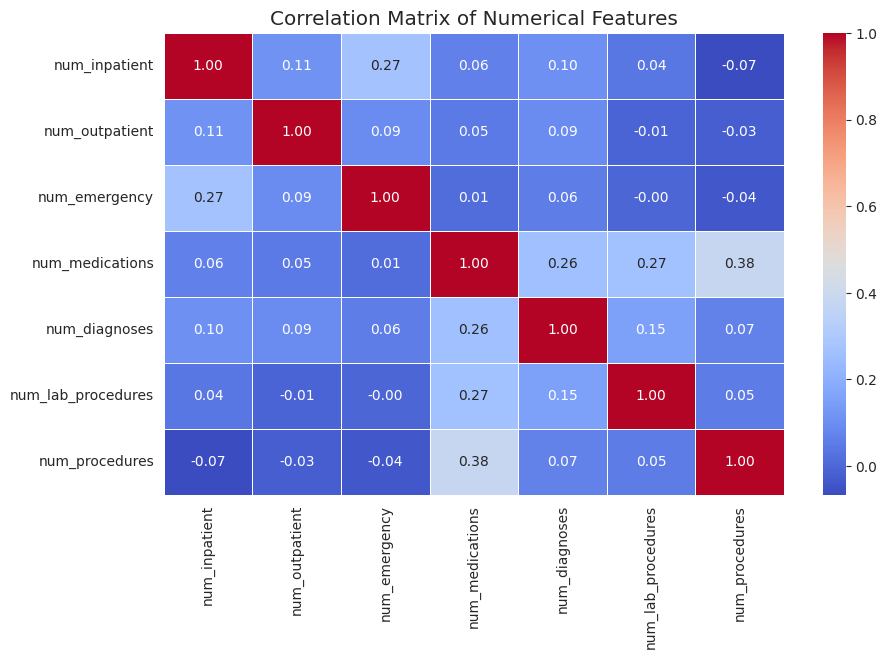

In [ ]:
temp_data = diabetic_data[['num_inpatient', 'num_outpatient', 'num_emergency', 'num_medications', 'num_diagnoses', 'num_lab_procedures', 'num_procedures']]
data_corr = temp_data.corr()

plt.figure(figsize=(10, 6))  # Set the figure size
sns.heatmap(data_corr, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

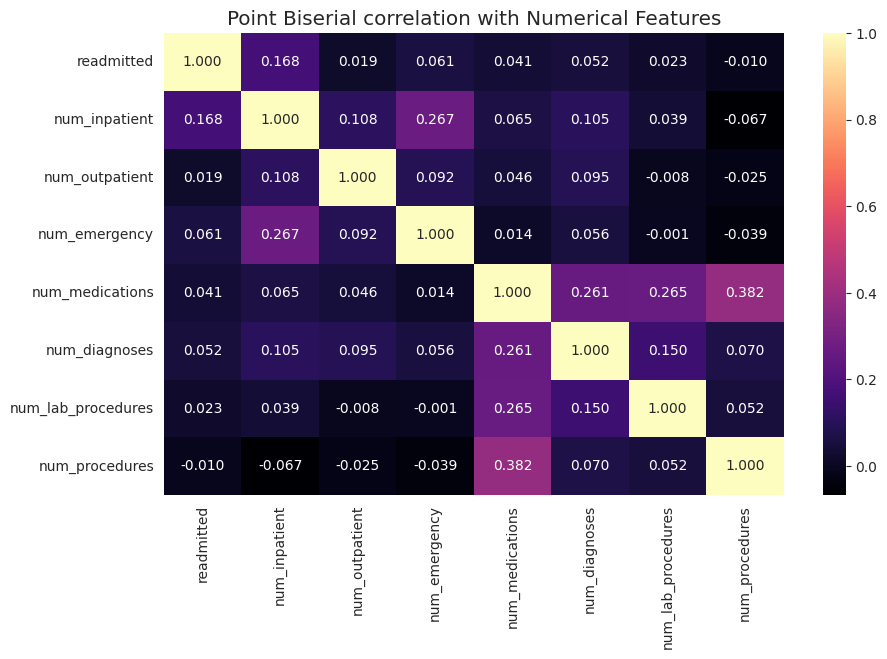

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size
point_biserial_matrix(
    data=diabetic_data,
    columns=['readmitted', 'num_inpatient', 'num_outpatient', 'num_emergency', 'num_medications', 'num_diagnoses', 'num_lab_procedures', 'num_procedures']
)
plt.title('Point Biserial correlation with Numerical Features')
plt.show()

#### 4.1.2 Diagnoses and hospital administration

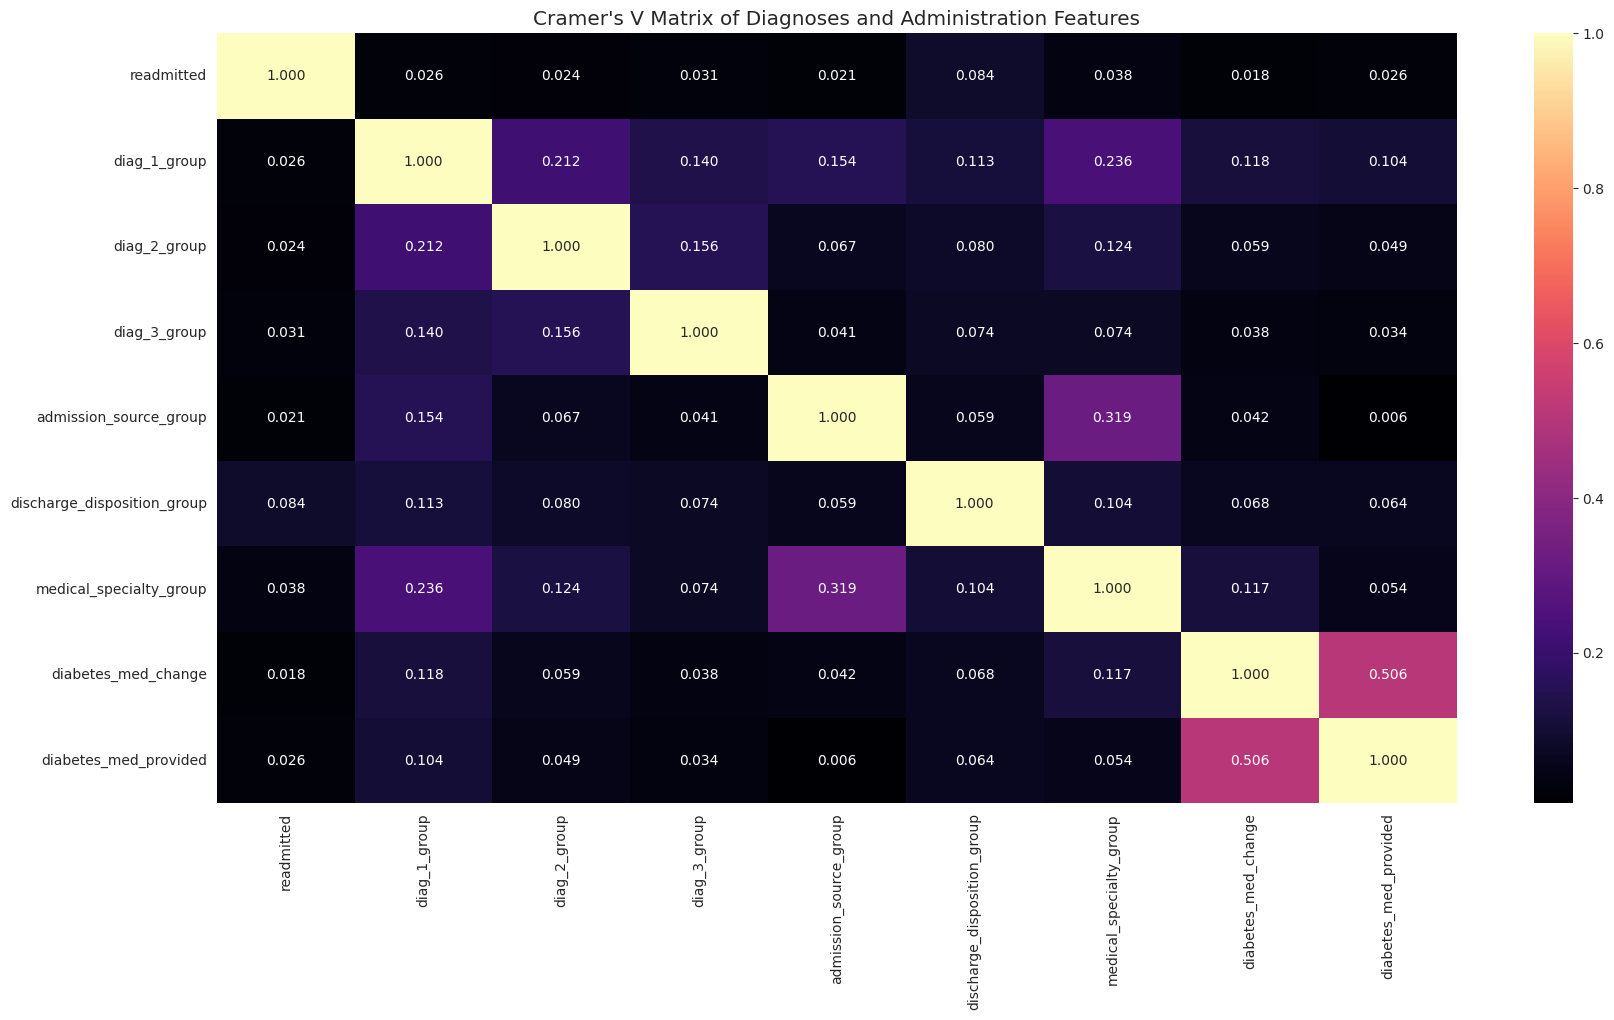

In [ ]:
plt.figure(figsize=(20, 10))  # Set the figure size
cramer_matrix(
    data=diabetic_data,
    columns=['readmitted', 'diag_1_group', 'diag_2_group', 'diag_3_group', 'admission_source_group', 'discharge_disposition_group', 'medical_specialty_group', 'diabetes_med_change', 'diabetes_med_provided']
)
plt.title("Cramer's V Matrix of Diagnoses and Administration Features")
plt.show()

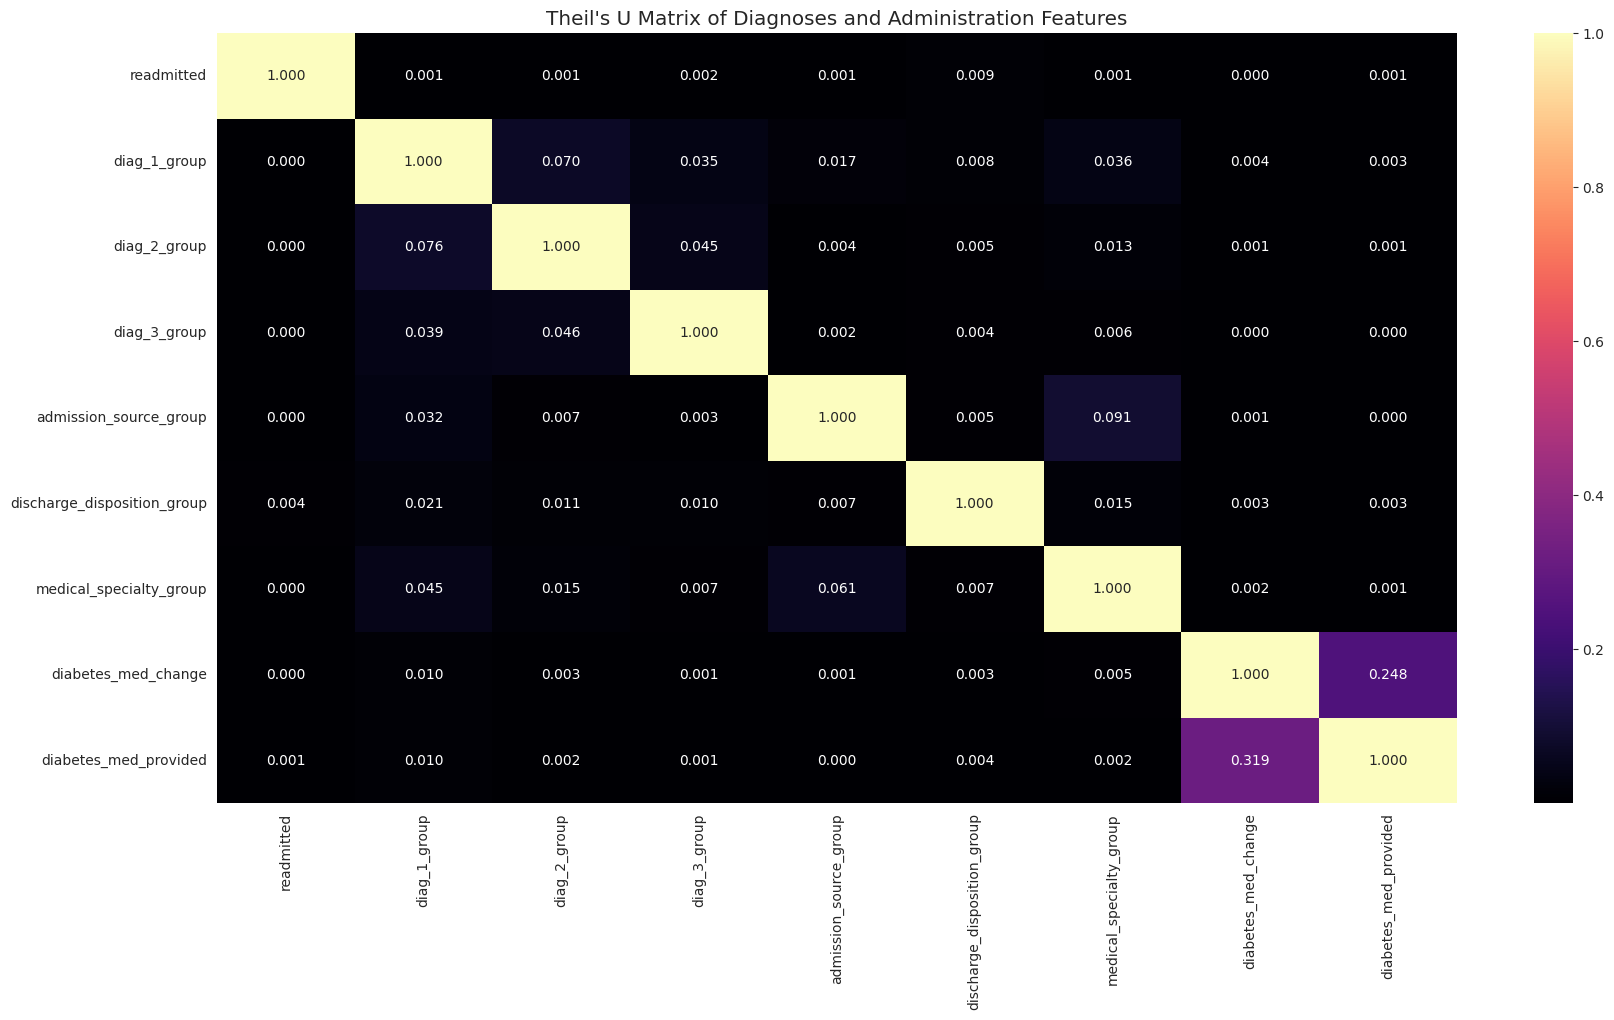

In [ ]:
plt.figure(figsize=(20, 10))  # Set the figure size
theil_matrix(
    data=diabetic_data,
    columns=['readmitted', 'diag_1_group', 'diag_2_group', 'diag_3_group', 'admission_source_group', 'discharge_disposition_group', 'medical_specialty_group', 'diabetes_med_change', 'diabetes_med_provided']
)
plt.title("Theil's U Matrix of Diagnoses and Administration Features")
plt.show()

#### 4.1.3 Medication groups
No association whatsoever between readmissions and medication groups.

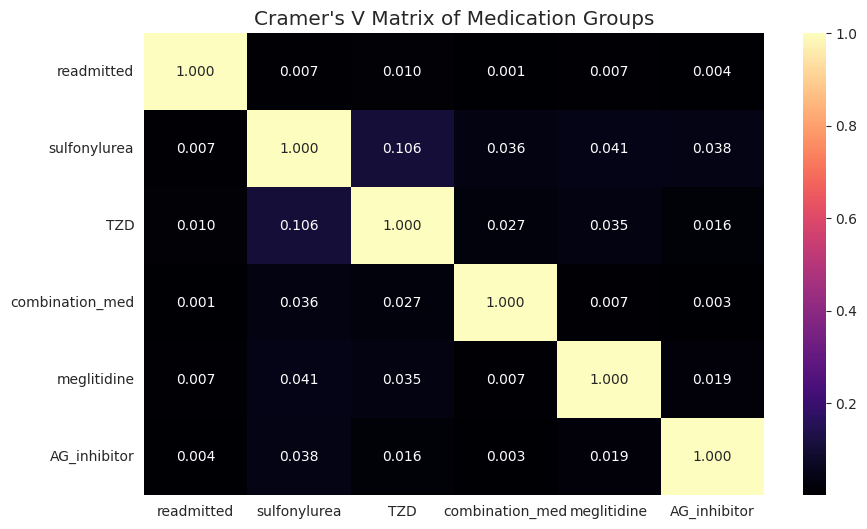

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size
cramer_matrix(
    data=diabetic_data,
    columns=['readmitted'] + list(diabetic_data.loc[:, 'sulfonylurea':'AG_inhibitor'].columns)
)
plt.title("Cramer's V Matrix of Medication Groups")
plt.show()

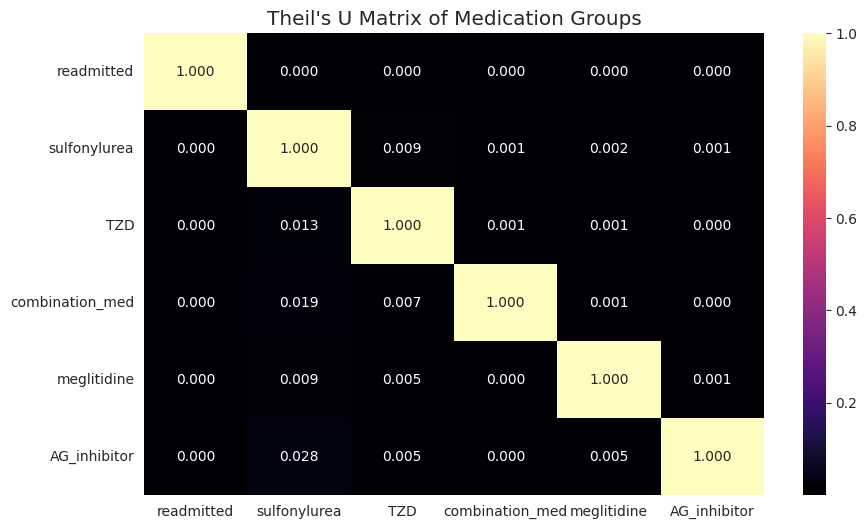

In [ ]:
plt.figure(figsize=(10, 6))  # Set the figure size
theil_matrix(
    data=diabetic_data,
    columns=['readmitted'] + list(diabetic_data.loc[:, 'sulfonylurea':'AG_inhibitor'].columns)
)
plt.title("Theil's U Matrix of Medication Groups")
plt.show()

### 4.2 Bivariate Analysis with Readmission

#### 4.2.1 Non-medication features

For **medical specialty**... **EVALUATE FURTHER**

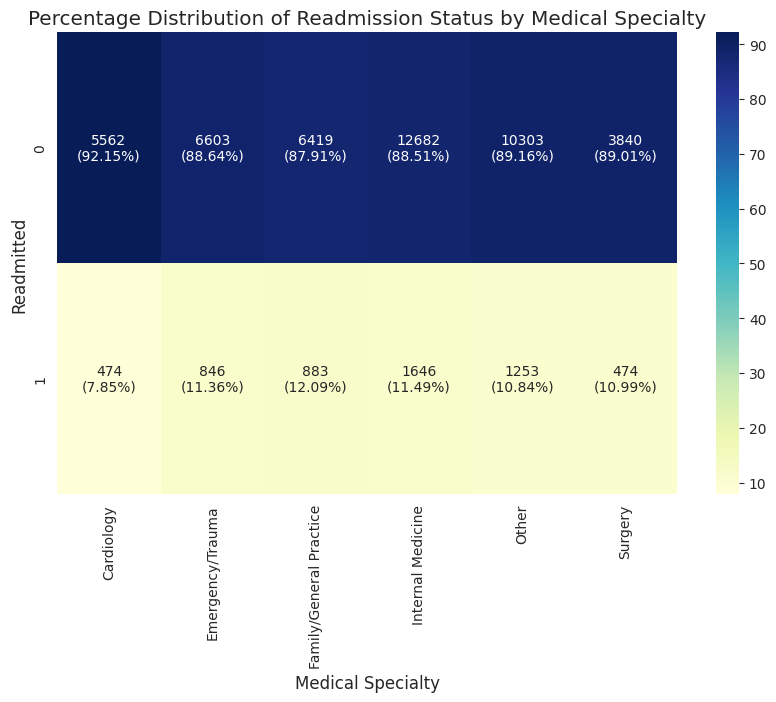

In [ ]:
plt.figure(figsize=(10, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='medical_specialty_group',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Medical Specialty')
plt.xlabel('Medical Specialty')
plt.ylabel('Readmitted')
plt.show()

For **primary_diagnosis**... **EVALUATE FURTHER**

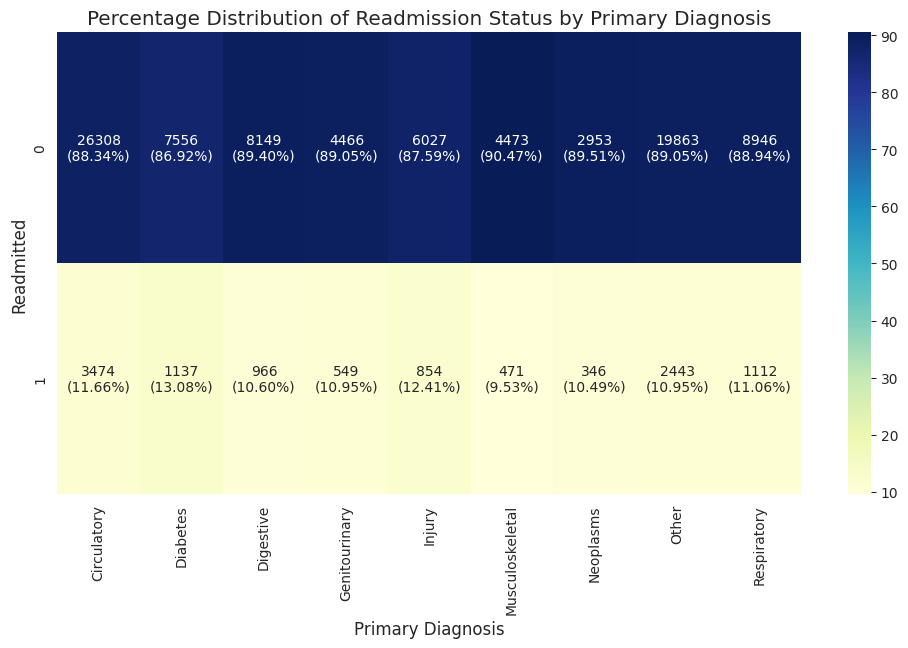

In [ ]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diag_1_group',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Primary Diagnosis')
plt.xlabel('Primary Diagnosis')
plt.ylabel('Readmitted')
plt.show()

For **secondary_diagnosis**... **EVALUATE FURTHER**

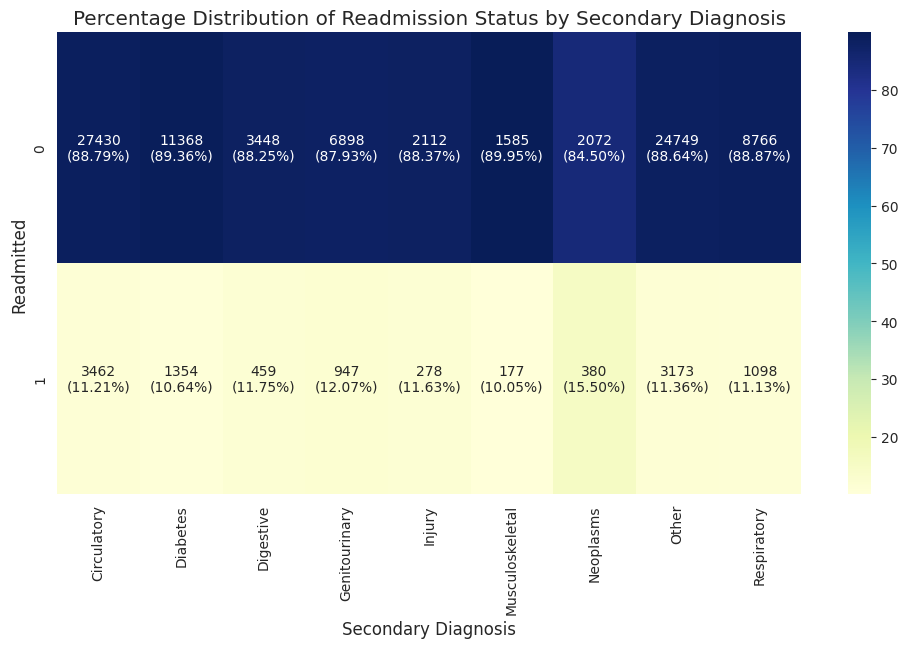

In [ ]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diag_2_group',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Secondary Diagnosis')
plt.xlabel('Secondary Diagnosis')
plt.ylabel('Readmitted')
plt.show()

For **tertiary_diagnosis**... **EVALUATE FURTHER**

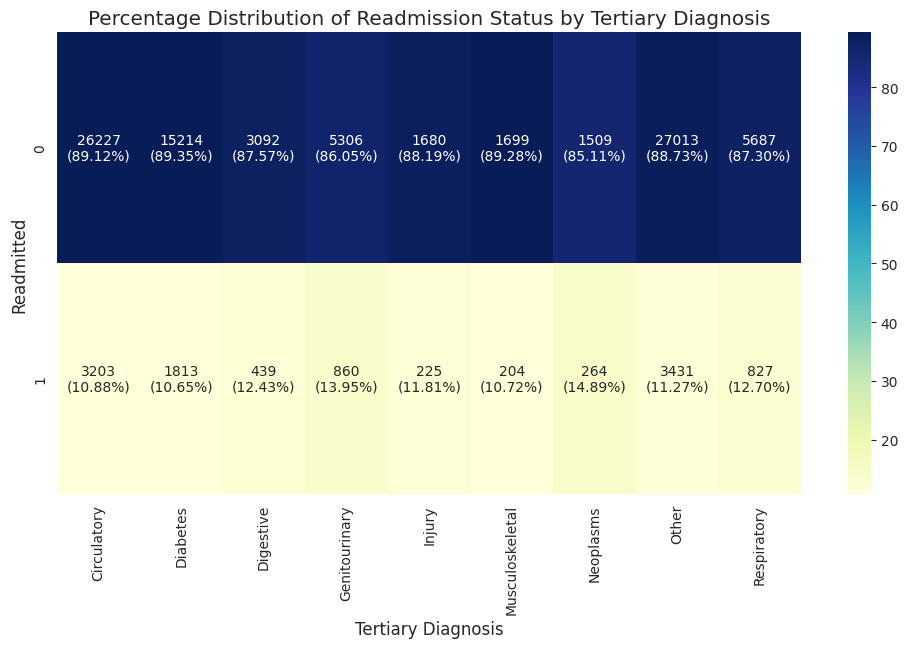

In [ ]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='diag_3_group',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Tertiary Diagnosis')
plt.xlabel('Tertiary Diagnosis')
plt.ylabel('Readmitted')
plt.show()

For **admission_source**... **EVALUATE FURTHER**

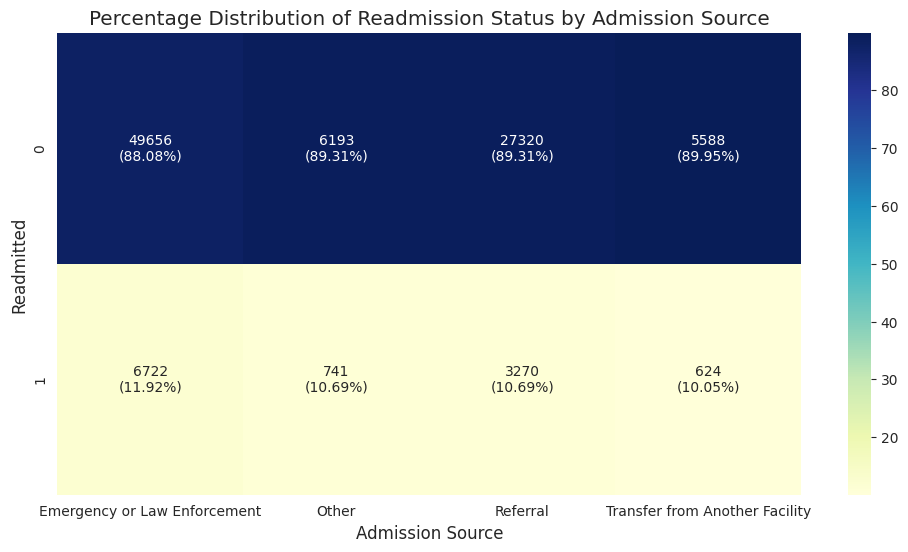

In [ ]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='admission_source_group',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Admission Source')
plt.xlabel('Admission Source')
plt.ylabel('Readmitted')
plt.show()

For **discharge_disposition**... **EVALUATE FURTHER**

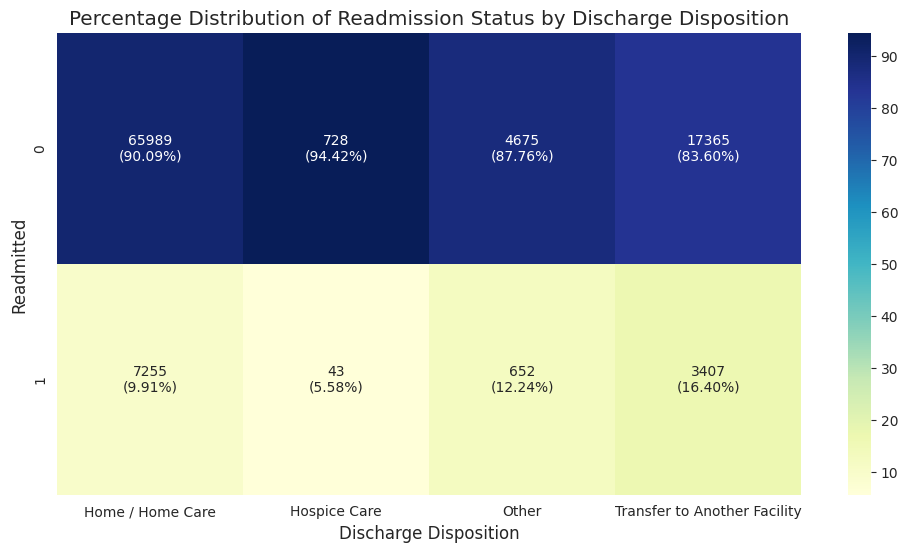

In [ ]:
plt.figure(figsize=(12, 6))
heatmap_crosstab(
    data=diabetic_data,
    x='discharge_disposition_group',
    y='readmitted',
    rows=[0, 1],
    # columns=[0, 1]
)


plt.title('Percentage Distribution of Readmission Status by Discharge Disposition')
plt.xlabel('Discharge Disposition')
plt.ylabel('Readmitted')
plt.show()

#### 4.2.2 Medication features